In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

$ vllm serve NousResearch/Hermes-2-Theta-Llama-3-8B --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-004 --port=8000 --api-key=default
INFO 03-14 14:42:28 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 14:42:28 api_server.py:912] vLLM API server version 0.7.3
INFO 03-14 14:42:28 api_server.py:913] args: Namespace(subparser='serve', model_tag='NousResearch/Hermes-2-Theta-Llama-3-8B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_ro

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.08it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.76it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.38it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.19it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.26it/s]



INFO 03-14 14:42:46 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-14 14:42:47 worker.py:267] Memory profiling takes 1.27 seconds
INFO 03-14 14:42:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-14 14:42:47 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-14 14:42:47 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-14 14:42:47 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-14 14:43:40 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 54.78 seconds
INFO 03-14 14:43:41 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-14 14:43:41 launcher.py:23] Available routes are:
INFO 03-14 14:43:41 launcher.py:31] Route: /openapi.json, Methods: HEAD

INFO:     Started server process [9427]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-14 14:43:42 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:33472 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


No "val/reward" metric found in history


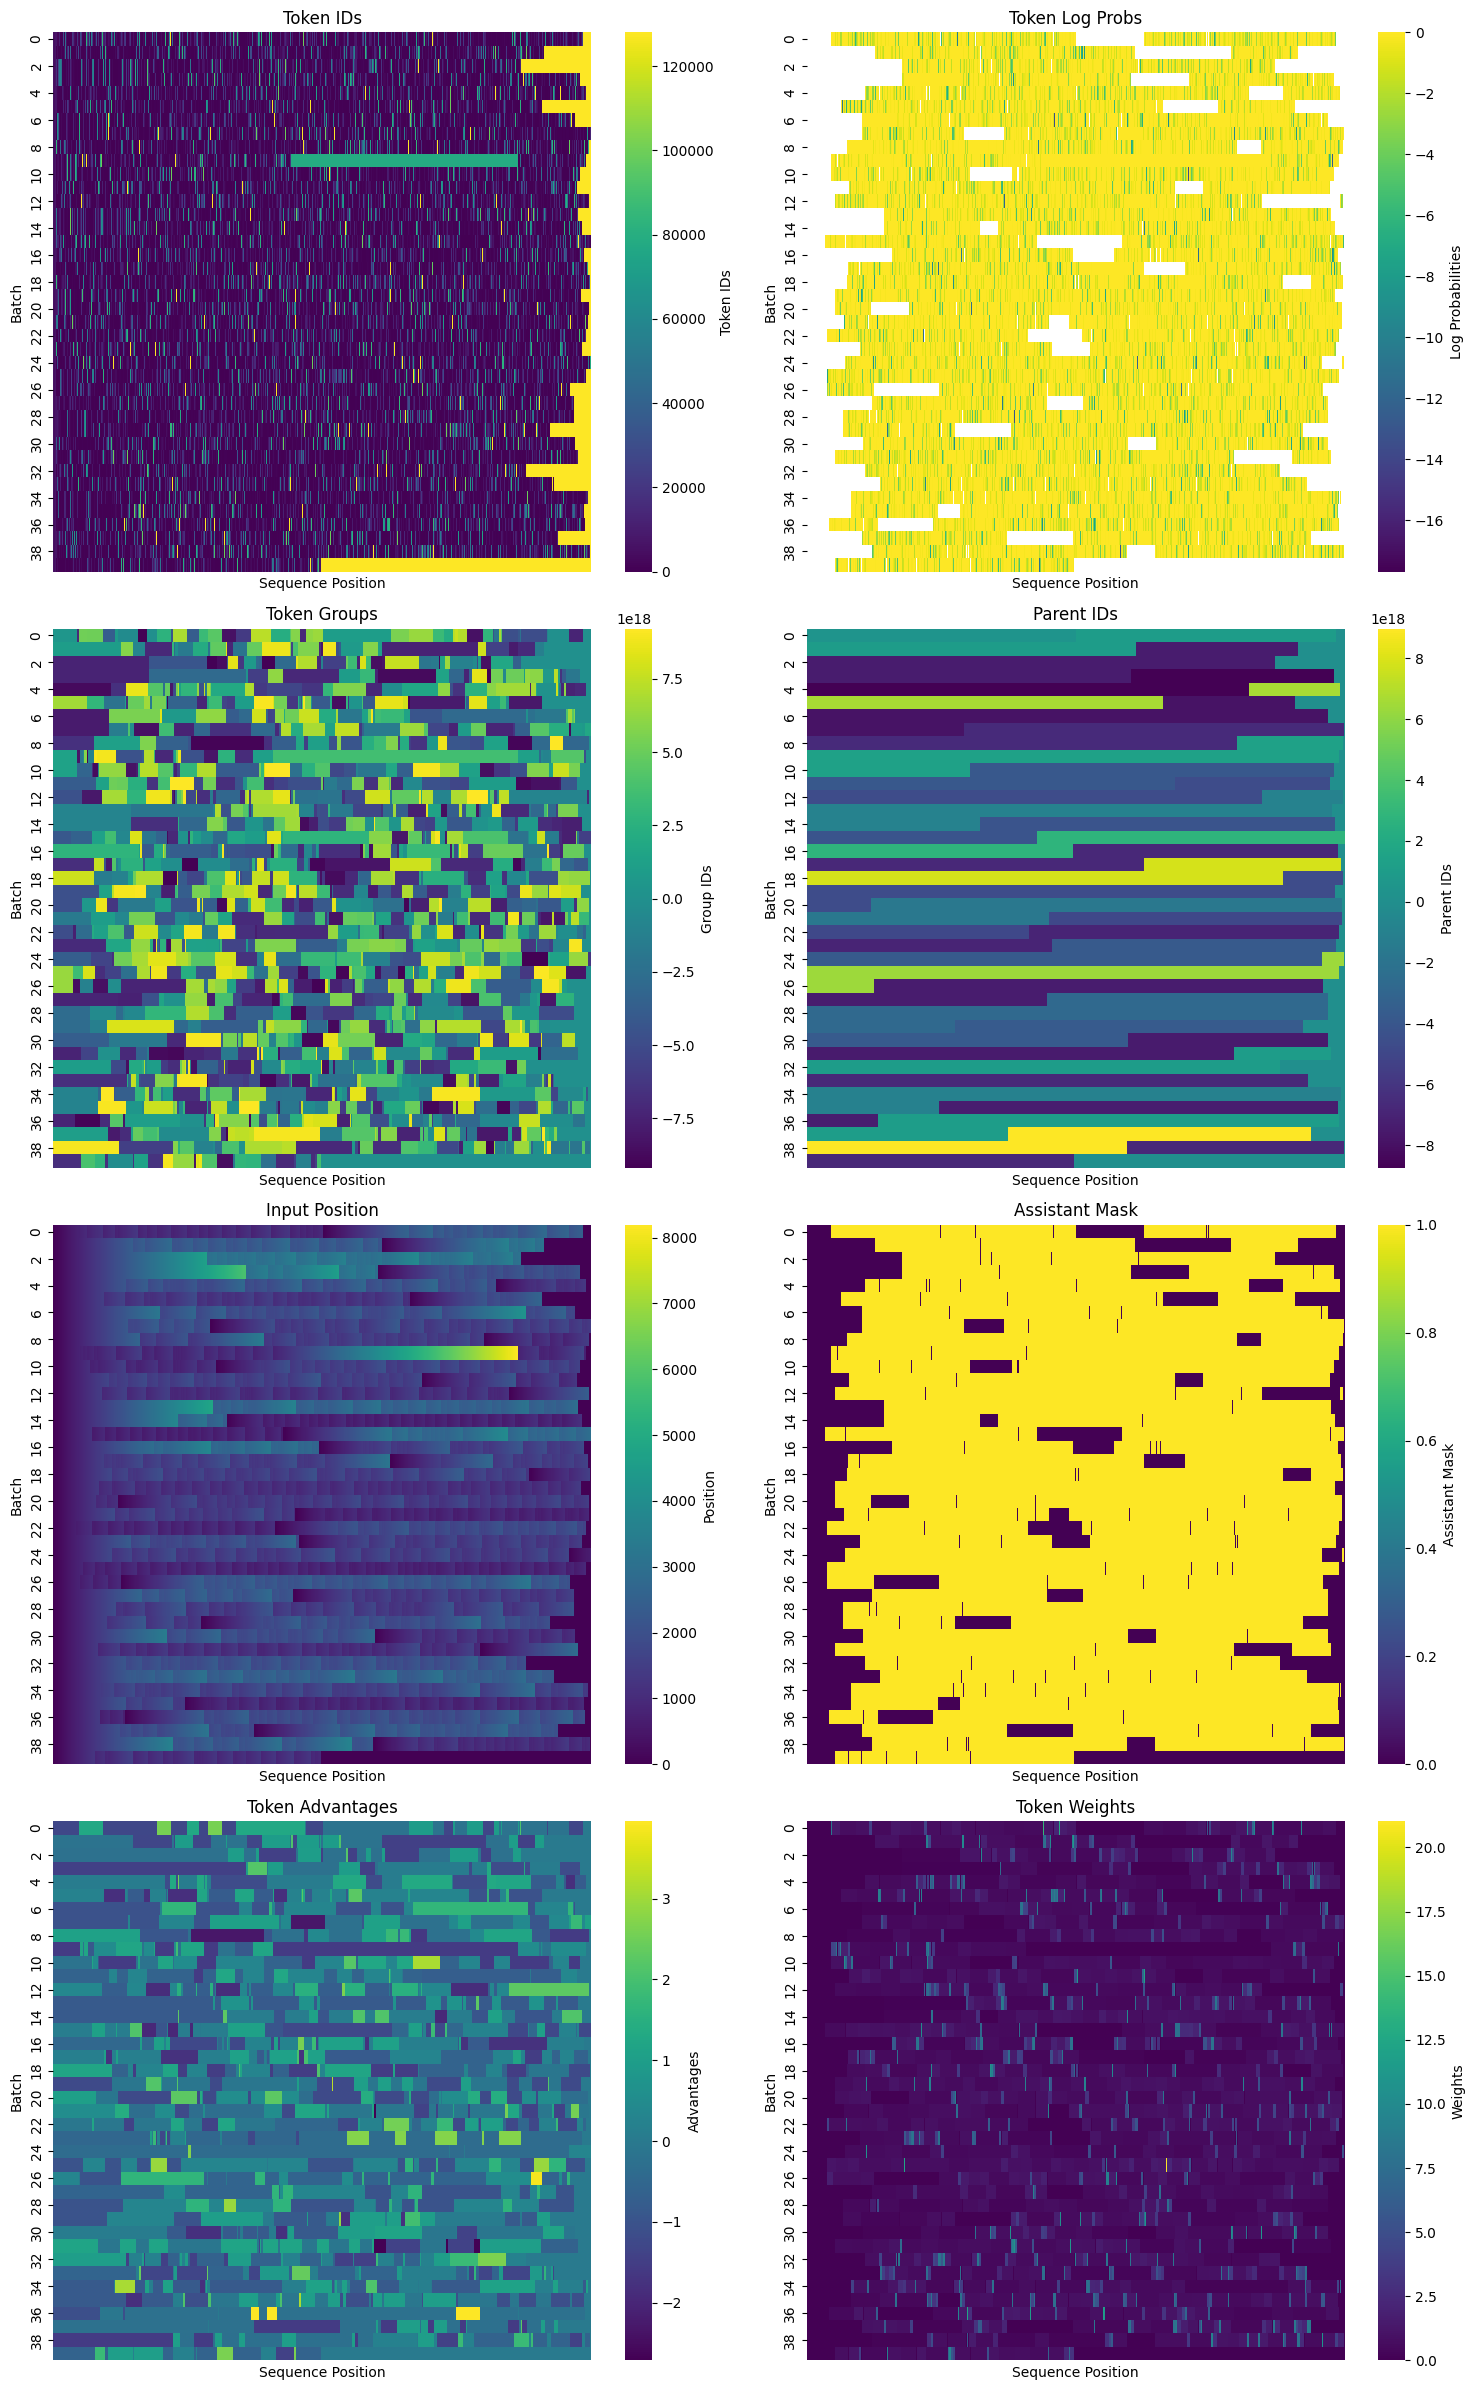

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-004/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725
  checkpoint_files:
  - model-00001-of-00004.safetensors
  - model-00004-of-00004.safetensors
  - model-00003-of-00004.safetensors
  - model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_

Writing logs to .art/models/temporal-clue-004/logs/log_1741963661.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.64 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|20|Loss: 0.0042: 100%|██████████| 20/20 [06:38<00:00, 19.58s/it, loss=0.00416, policy=0.00416, entropy=0.5, kl_div=nan]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0001 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-004 --port=8000 --api-key=default
INFO 03-14 14:54:57 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 14:54:57 api_server.py:912] vLLM API server version 0.7.3
INFO 03-14 14:54:57 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_tem

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.84it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.60it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.26it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.14it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.28it/s]



INFO 03-14 14:55:13 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-14 14:55:14 worker.py:267] Memory profiling takes 1.25 seconds
INFO 03-14 14:55:14 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-14 14:55:14 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-14 14:55:14 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-14 14:55:14 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-14 14:56:09 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 56.19 seconds
INFO 03-14 14:56:10 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-14 14:56:10 launcher.py:23] Available routes are:
INFO 03-14 14:56:10 launcher.py:31] Route: /openapi.json, Methods: GET,

INFO:     Started server process [10128]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-14 14:56:15 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 03-14 14:56:15 metrics.py:455] Avg prompt throughput: 1.9 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 03-14 14:56:15 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:40258 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

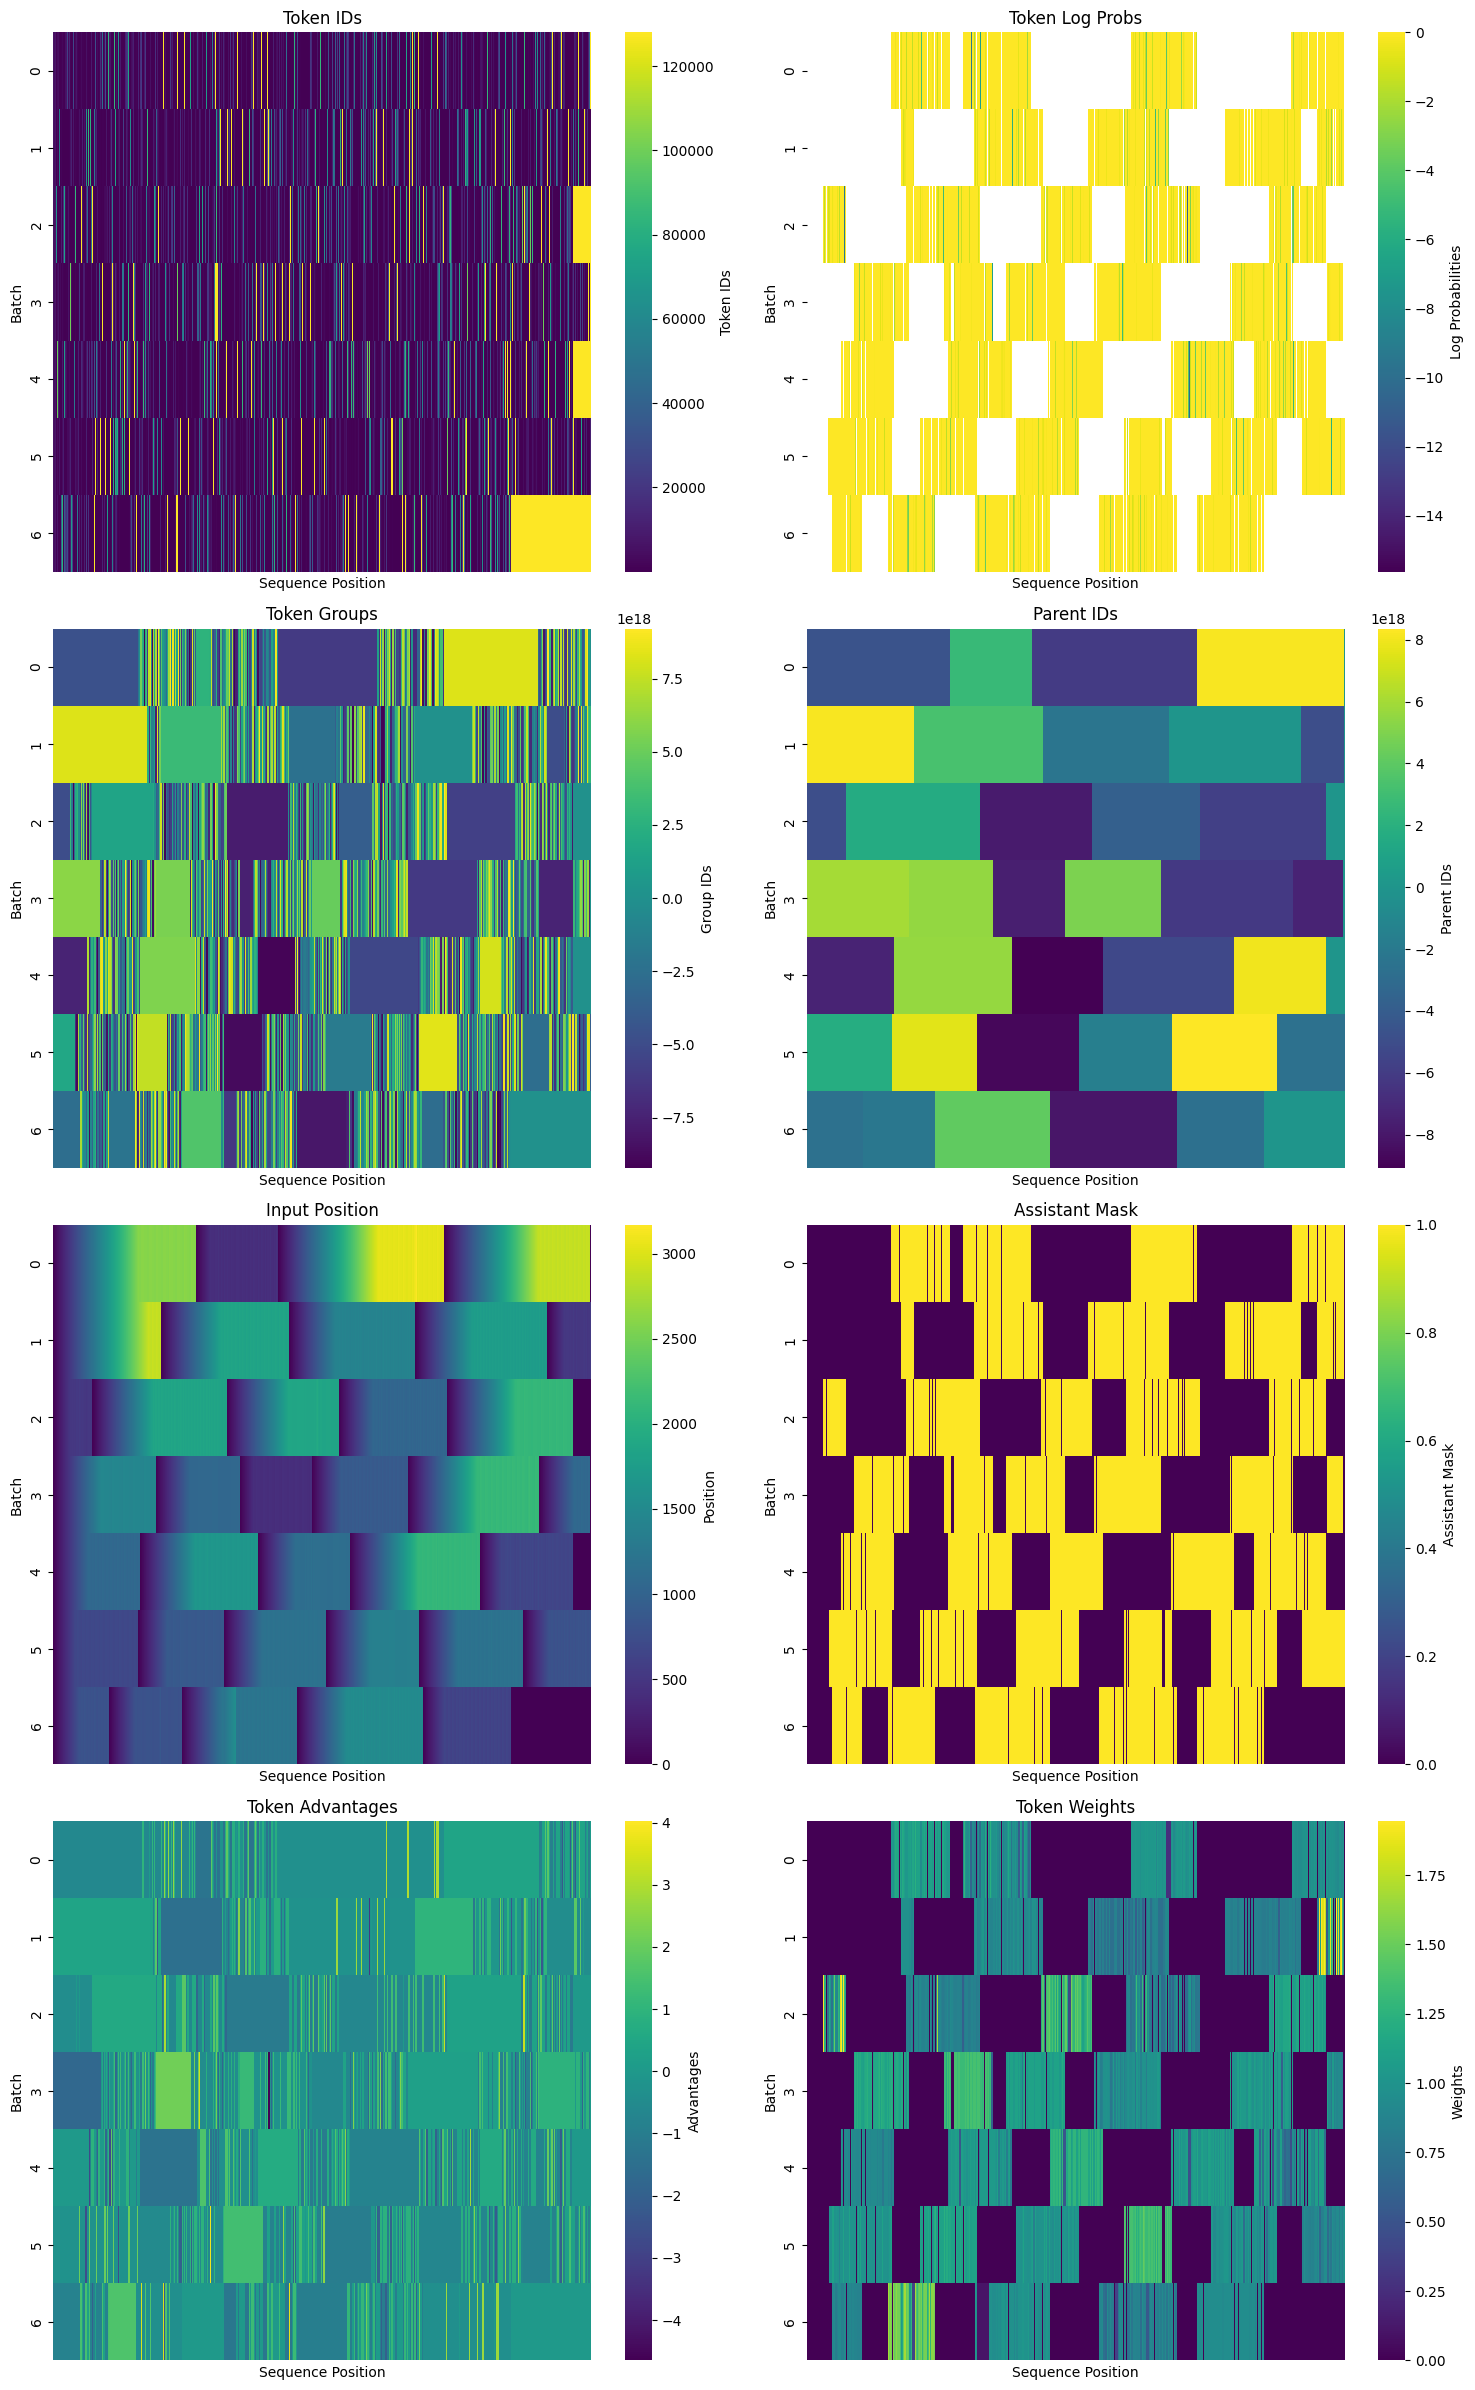

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-004/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-004/0001
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-004
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-004/logs/log_1741964261.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.65 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|3|Loss: 0.0515: 100%|██████████| 3/3 [01:03<00:00, 20.45s/it, loss=0.0515, policy=0.0515, entropy=0.124, kl_div=nan]      INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0002 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-004 --port=8000 --api-key=default
INFO 03-14 14:59:21 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 14:59:21 api_server.py:912] vLLM API server version 0.7.3
INFO 03-14 14:59:21 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0002', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_tem

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.59it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.60it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.26it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.14it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.28it/s]



INFO 03-14 14:59:39 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-14 14:59:40 worker.py:267] Memory profiling takes 1.18 seconds
INFO 03-14 14:59:40 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-14 14:59:40 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-14 14:59:40 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-14 14:59:40 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-14 15:00:28 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 49.44 seconds
INFO 03-14 15:00:29 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-14 15:00:29 launcher.py:23] Available routes are:
INFO 03-14 15:00:29 launcher.py:31] Route: /openapi.json, Methods: GET,

INFO:     Started server process [10706]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-14 15:00:31 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:46670 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

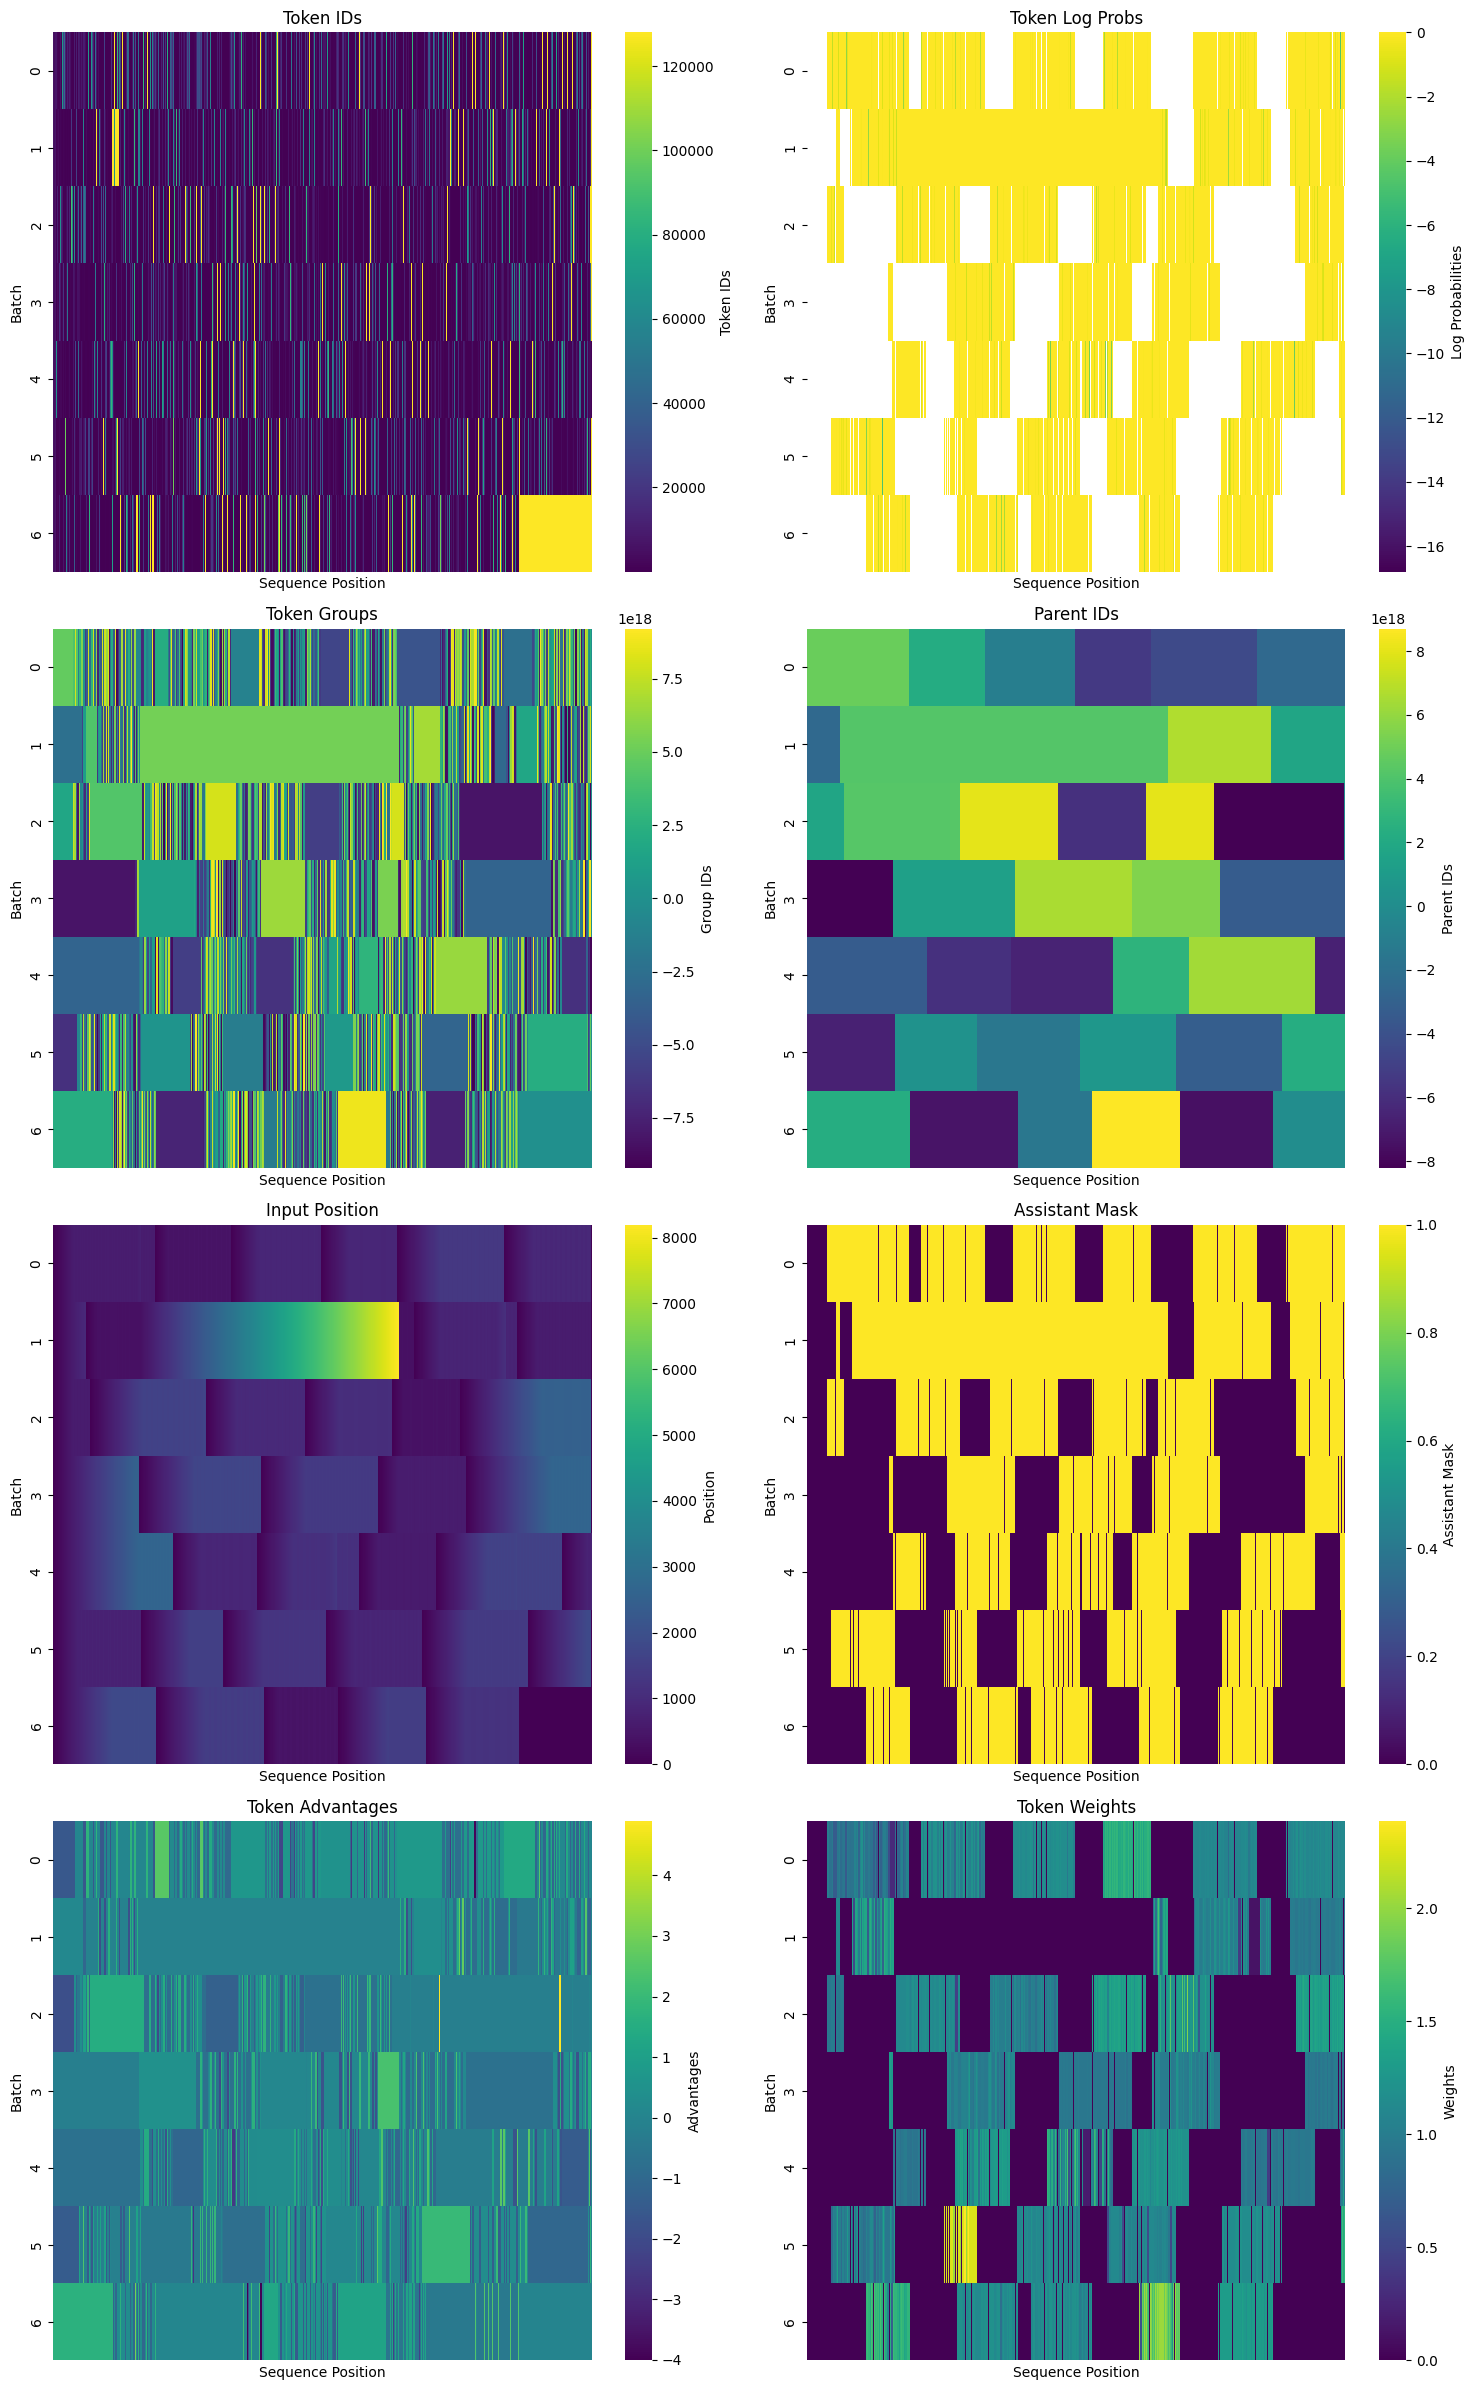

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-004/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-004/0002
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-004
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-004/logs/log_1741964579.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.46 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|3|Loss: 0.0399: 100%|██████████| 3/3 [01:03<00:00, 20.42s/it, loss=0.0399, policy=0.0399, entropy=0.0929, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0003 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-004 --port=8000 --api-key=default
INFO 03-14 15:04:38 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 15:04:38 api_server.py:912] vLLM API server version 0.7.3
INFO 03-14 15:04:38 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0003', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_tem

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  6.16it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:00<00:00,  2.04it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.63it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.43it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.61it/s]



INFO 03-14 15:04:53 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-14 15:04:54 worker.py:267] Memory profiling takes 1.08 seconds
INFO 03-14 15:04:54 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-14 15:04:54 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-14 15:04:54 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-14 15:04:54 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-14 15:05:45 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 52.35 seconds
INFO 03-14 15:05:46 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-14 15:05:46 launcher.py:23] Available routes are:
INFO 03-14 15:05:46 launcher.py:31] Route: /openapi.json, Methods: GET,

INFO:     Started server process [11333]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-14 15:05:53 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 03-14 15:05:54 metrics.py:455] Avg prompt throughput: 1.3 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 03-14 15:05:54 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:48610 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/temporal-clue-004/0001


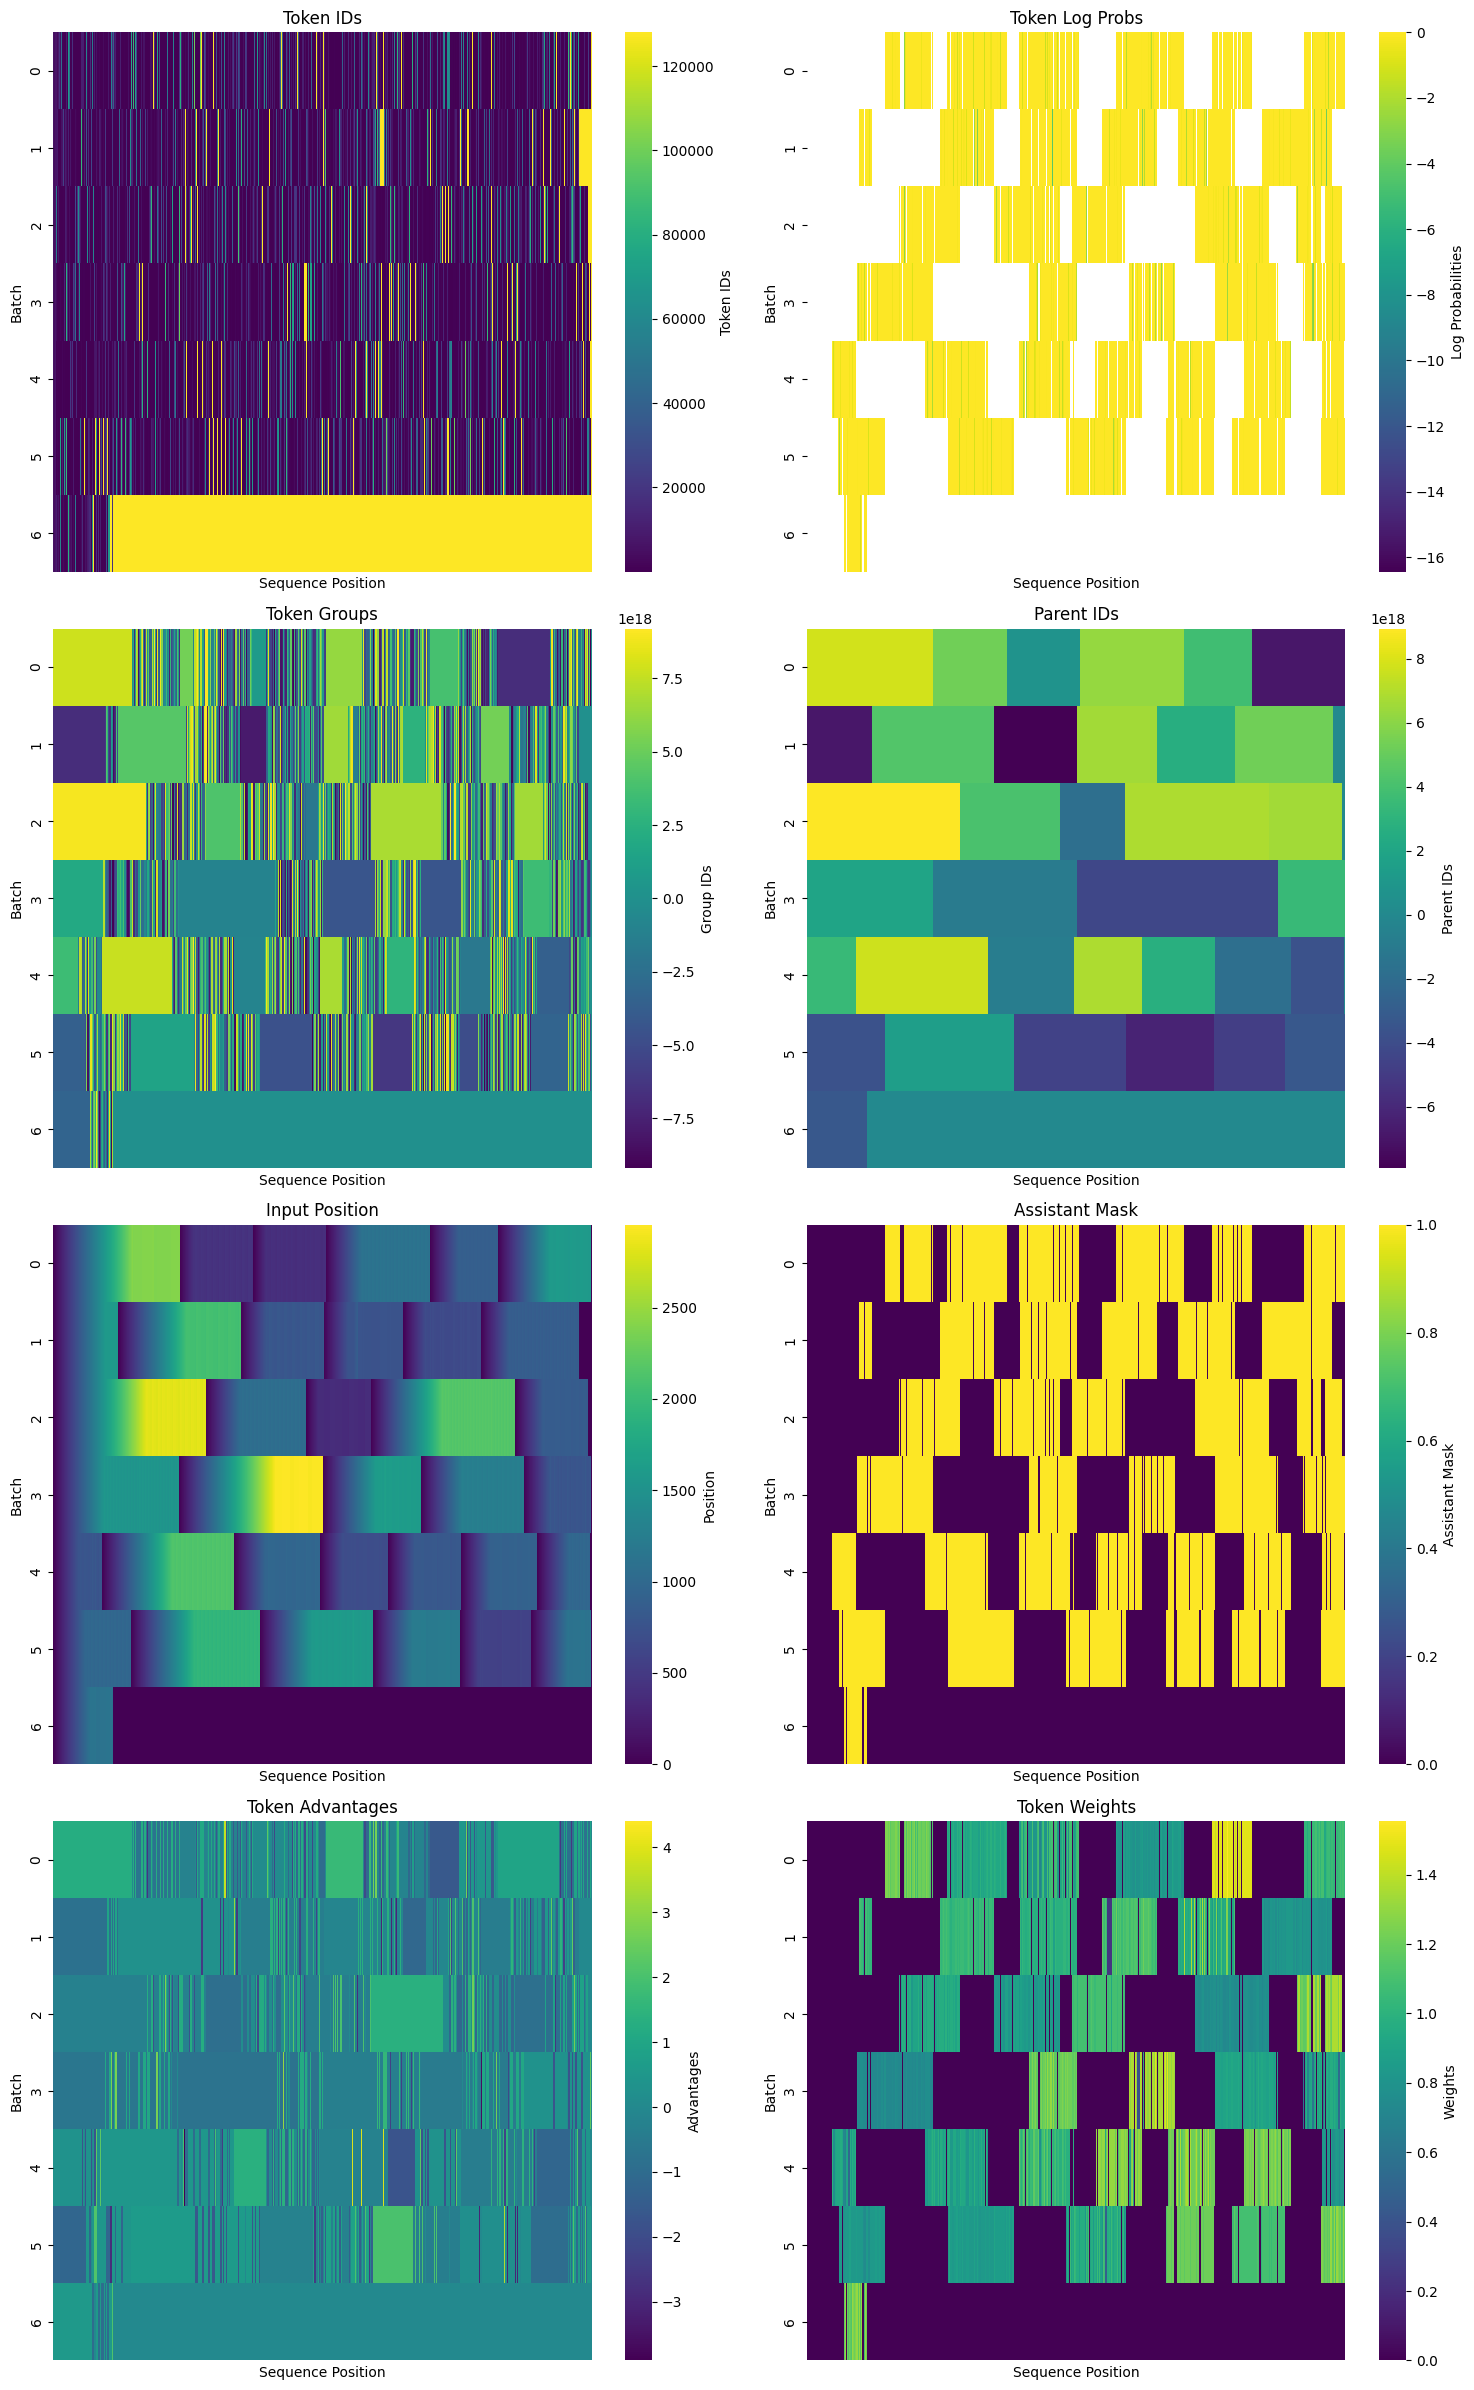

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-004/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-004/0003
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-004
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-004/logs/log_1741964845.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.92 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|3|Loss: 0.0266: 100%|██████████| 3/3 [01:03<00:00, 20.60s/it, loss=0.0266, policy=0.0266, entropy=0.0761, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0004 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-004 --port=8000 --api-key=default
INFO 03-14 15:09:07 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 15:09:07 api_server.py:912] vLLM API server version 0.7.3
INFO 03-14 15:09:07 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0004', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_tem

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.82it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.61it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.26it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.10it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.25it/s]



INFO 03-14 15:09:23 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-14 15:09:25 worker.py:267] Memory profiling takes 1.25 seconds
INFO 03-14 15:09:25 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-14 15:09:25 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-14 15:09:25 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-14 15:09:25 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-14 15:10:17 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 53.27 seconds
INFO 03-14 15:10:18 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-14 15:10:18 launcher.py:23] Available routes are:
INFO 03-14 15:10:18 launcher.py:31] Route: /openapi.json, Methods: GET,

INFO:     Started server process [11819]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-14 15:10:20 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:53756 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/temporal-clue-004/0002


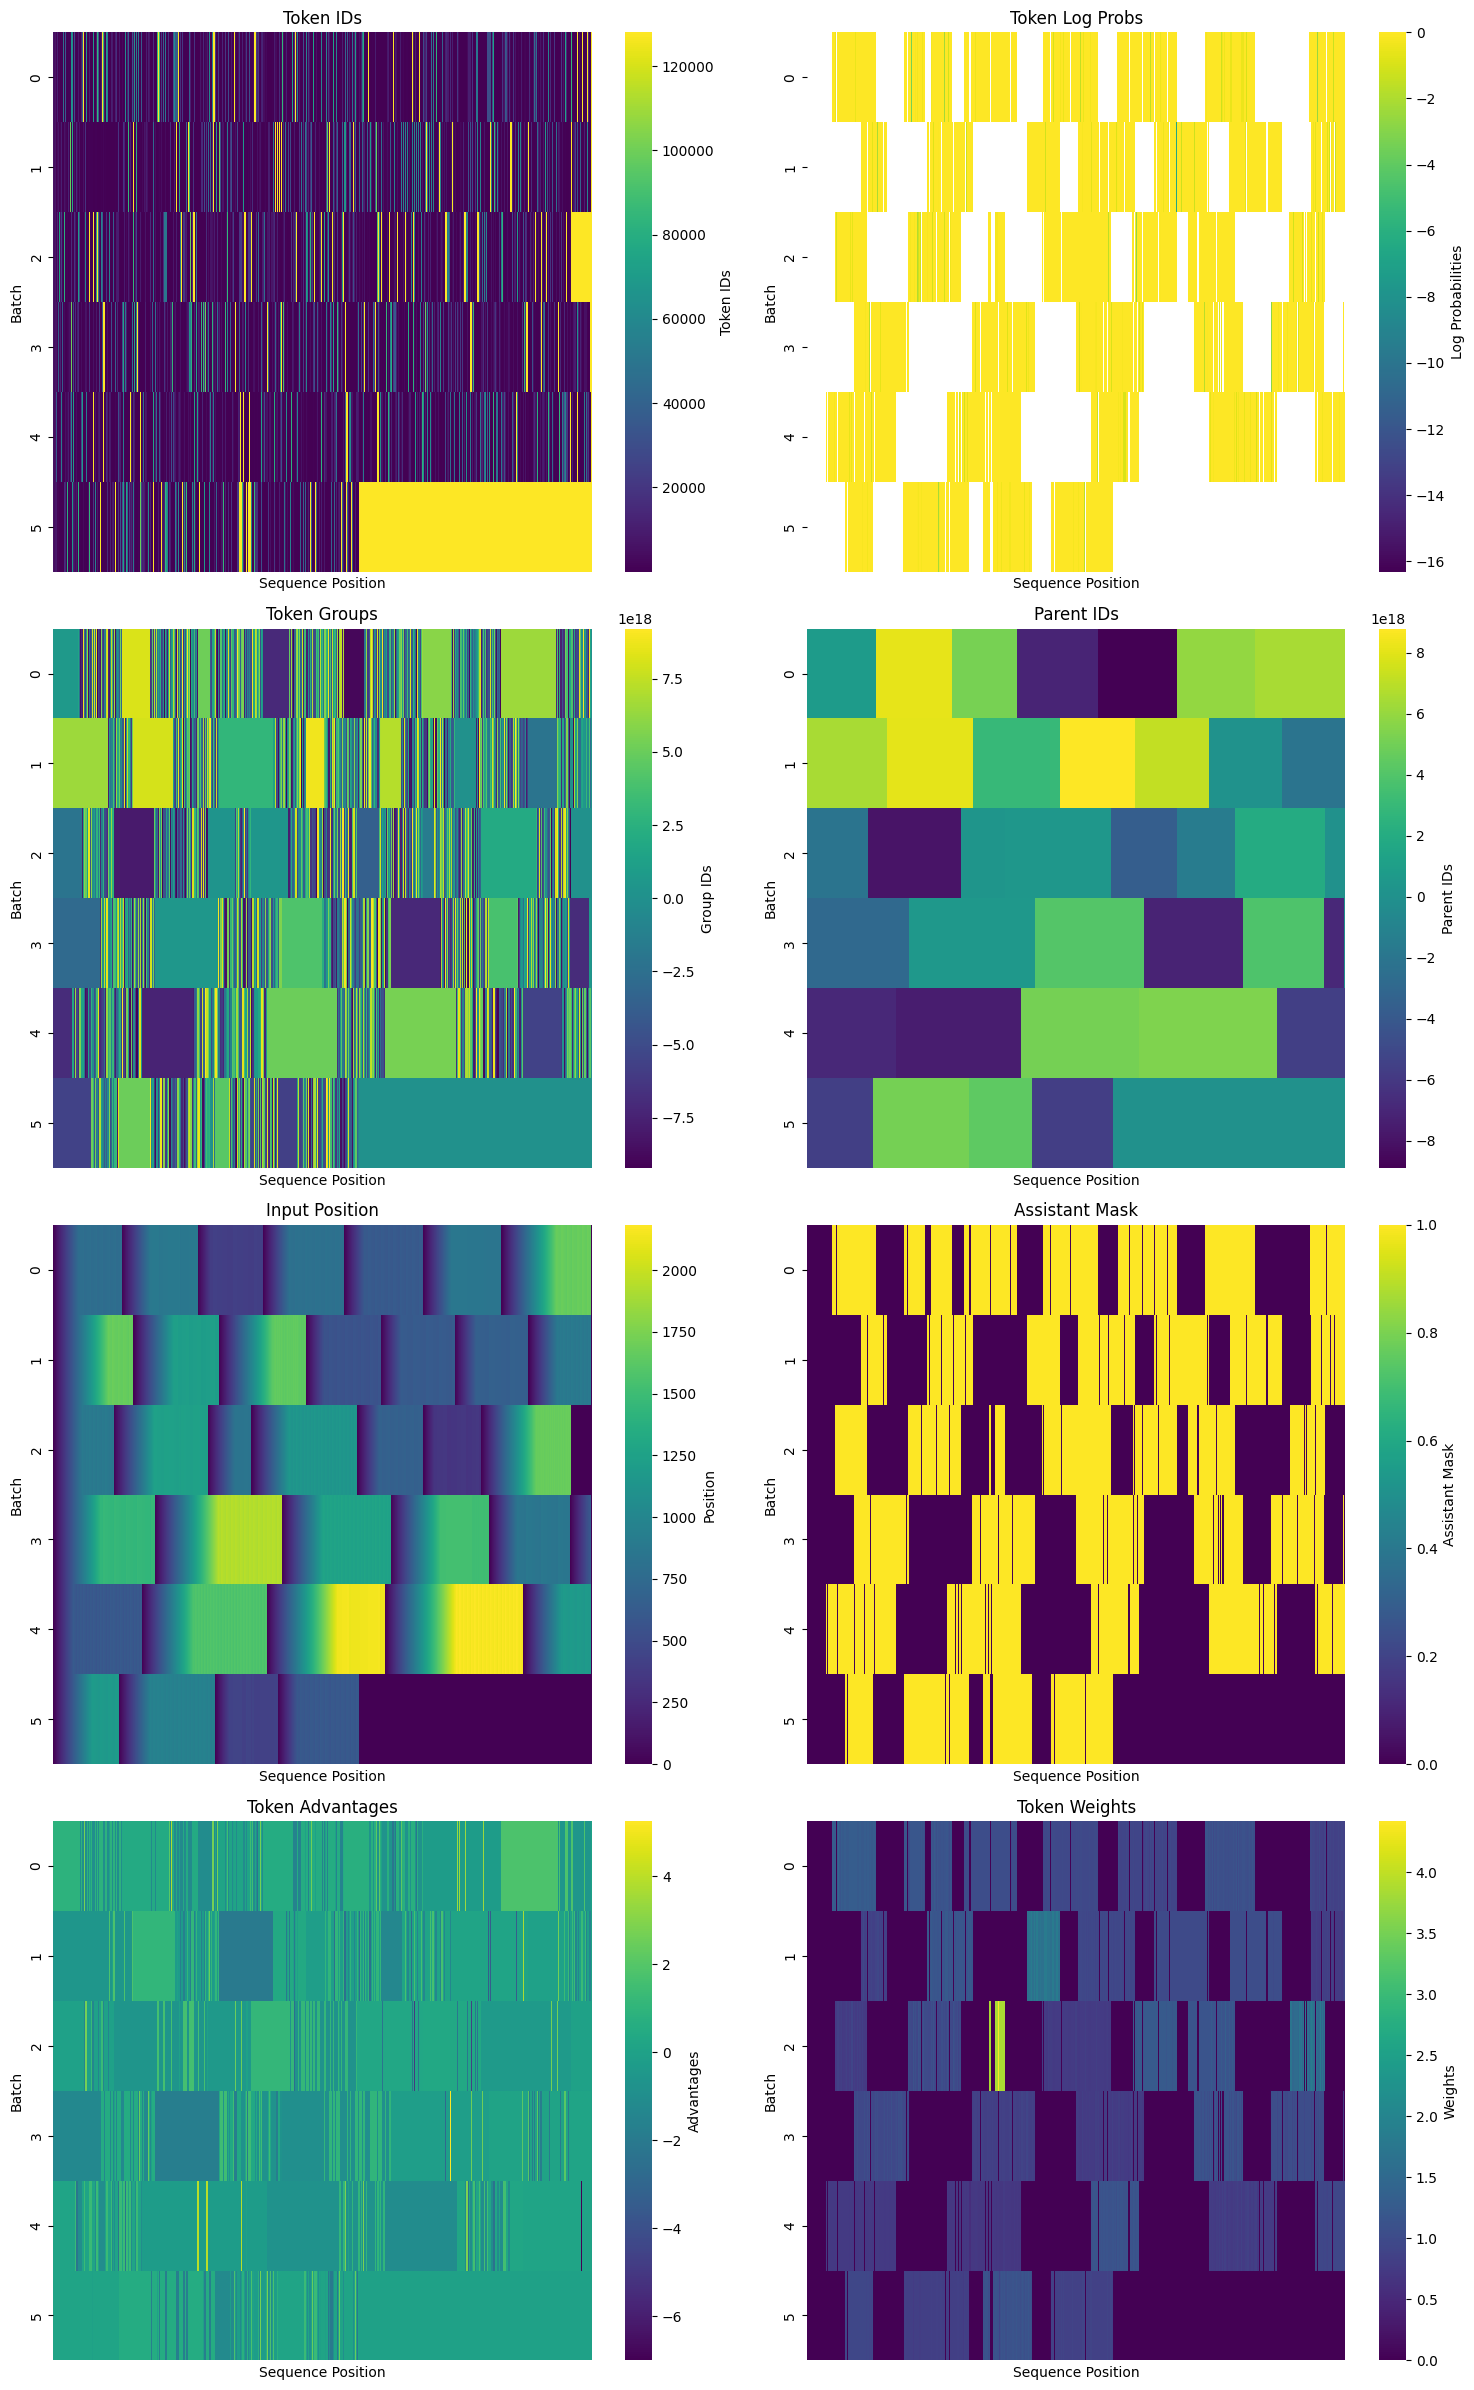

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-004/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-004/0004
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-004
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-004/logs/log_1741965096.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.91 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|3|Loss: 0.0009: 100%|██████████| 3/3 [01:06<00:00, 21.09s/it, loss=0.000859, policy=0.000859, entropy=0.0569, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...


$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0005 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-004 --port=8000 --api-key=default
INFO 03-14 15:13:20 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 15:13:20 api_server.py:912] vLLM API server version 0.7.3
INFO 03-14 15:13:20 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0005', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_tem

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.75it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.60it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.25it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.10it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.25it/s]



INFO 03-14 15:13:37 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-14 15:13:38 worker.py:267] Memory profiling takes 1.21 seconds
INFO 03-14 15:13:38 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-14 15:13:38 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-14 15:13:38 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-14 15:13:38 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-14 15:14:30 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 52.88 seconds
INFO 03-14 15:14:31 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-14 15:14:31 launcher.py:23] Available routes are:
INFO 03-14 15:14:31 launcher.py:31] Route: /openapi.json, Methods: HEAD

INFO:     Started server process [12276]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-14 15:14:33 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:58618 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/temporal-clue-004/0004


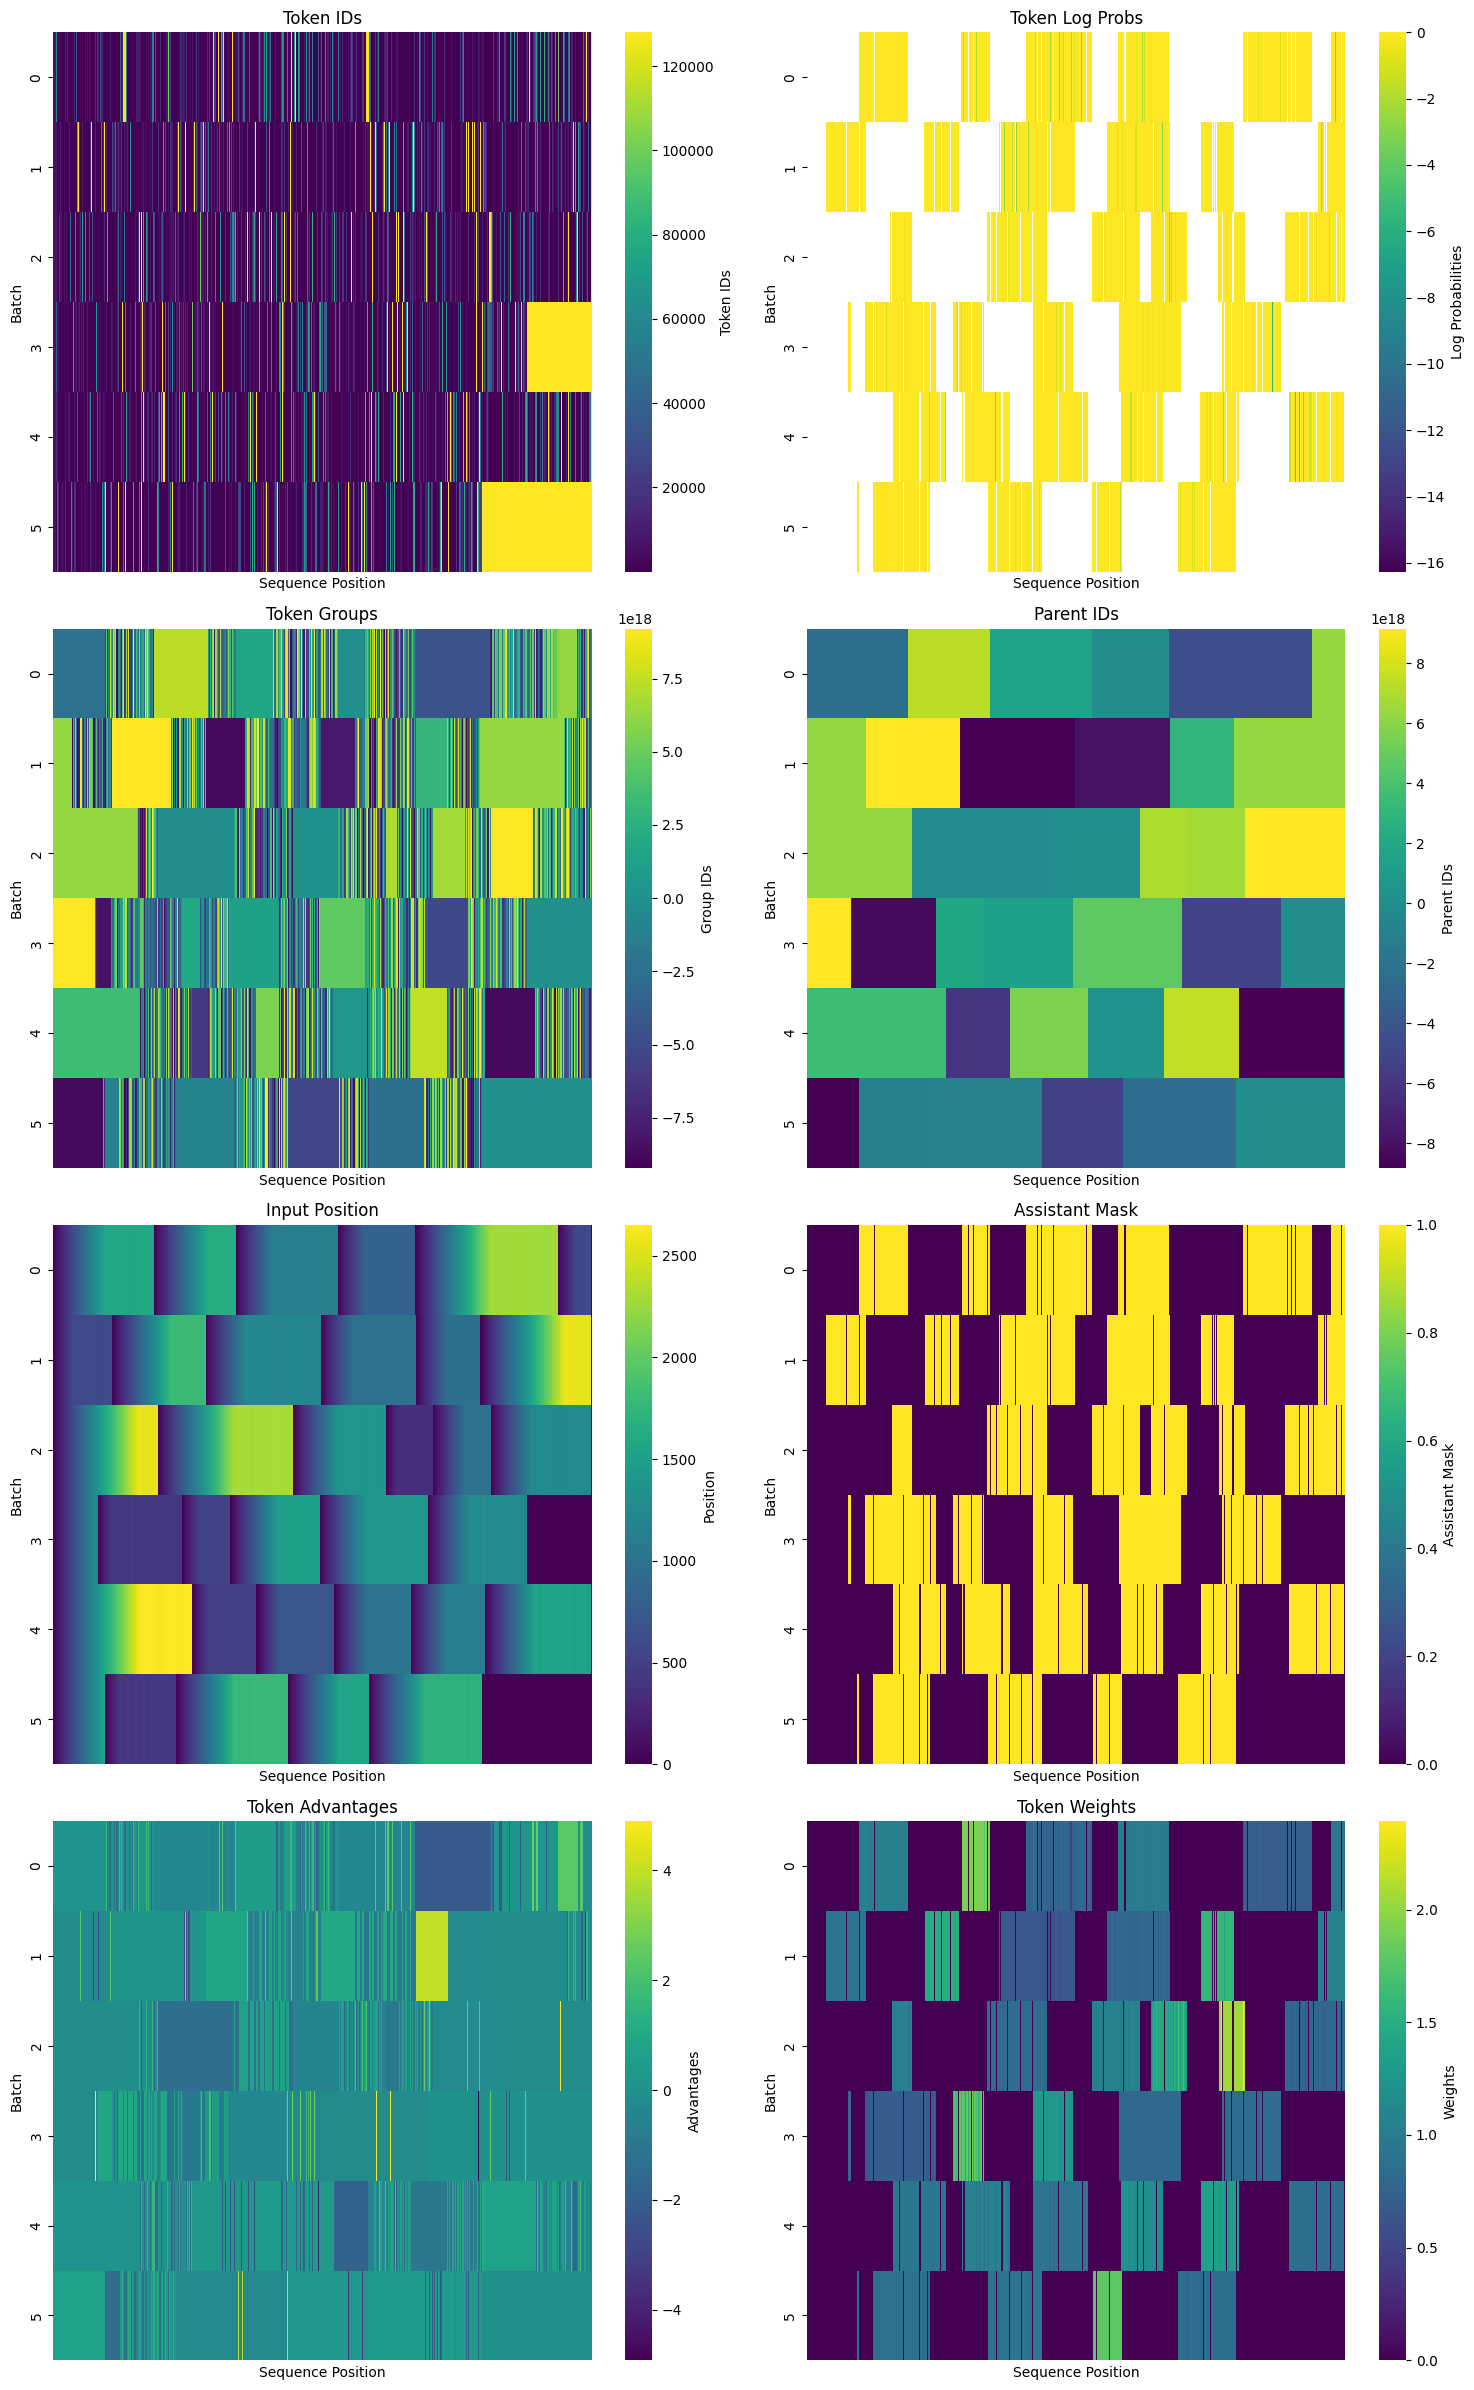

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-004/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-004/0005
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-004
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-004/logs/log_1741965358.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.29 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|3|Loss: 0.0412: 100%|██████████| 3/3 [01:06<00:00, 21.19s/it, loss=0.0412, policy=0.0412, entropy=0.0494, kl_div=nan]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0006 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-004 --port=8000 --api-key=default
INFO 03-14 15:17:40 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 15:17:40 api_server.py:912] vLLM API server version 0.7.3
INFO 03-14 15:17:40 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0006', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_tem

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  5.87it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:00<00:00,  2.03it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.58it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.34it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.54it/s]



INFO 03-14 15:17:57 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-14 15:17:58 worker.py:267] Memory profiling takes 1.08 seconds
INFO 03-14 15:17:58 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-14 15:17:58 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-14 15:17:58 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-14 15:17:58 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-14 15:18:49 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 52.68 seconds
INFO 03-14 15:18:50 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-14 15:18:50 launcher.py:23] Available routes are:
INFO 03-14 15:18:50 launcher.py:31] Route: /openapi.json, Methods: GET,

INFO:     Started server process [12749]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-14 15:18:58 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 03-14 15:18:59 metrics.py:455] Avg prompt throughput: 1.2 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 03-14 15:18:59 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:56124 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/temporal-clue-004/0003


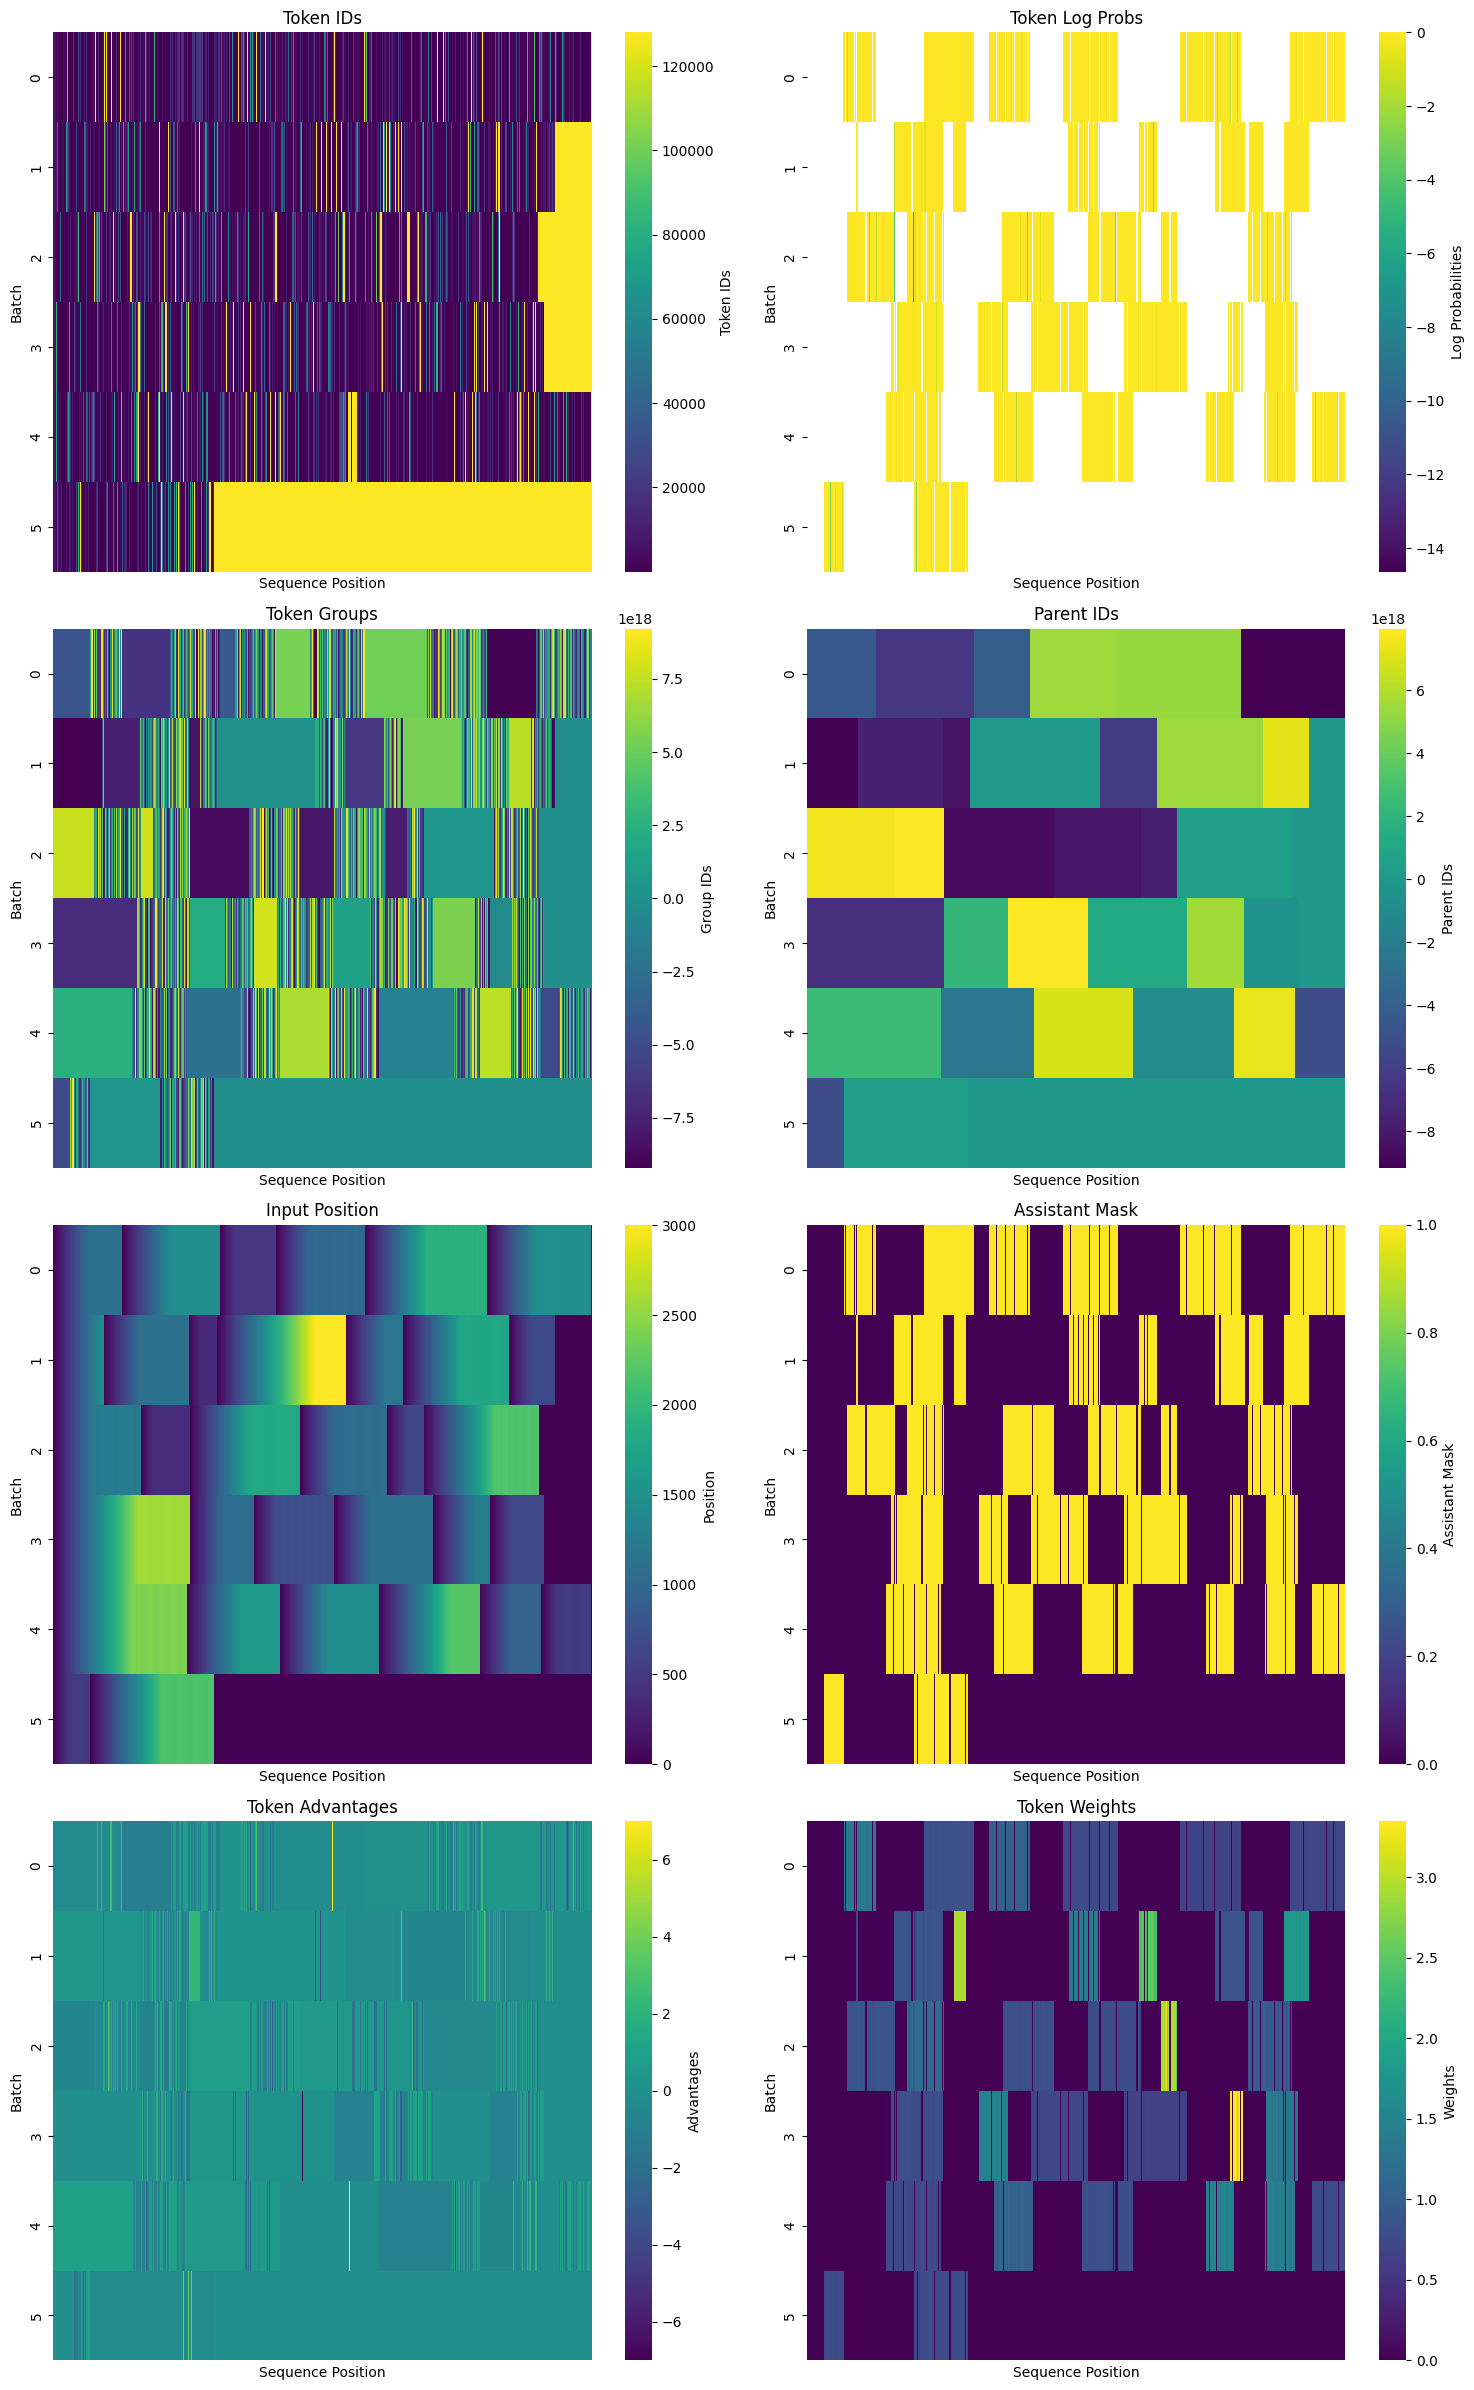

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-004/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-004/0006
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-004
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-004/logs/log_1741965632.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.29 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|3|Loss: 0.0595: 100%|██████████| 3/3 [01:04<00:00, 20.78s/it, loss=0.0595, policy=0.0595, entropy=0.0643, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0007 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-004 --port=8000 --api-key=default
INFO 03-14 15:22:12 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 15:22:12 api_server.py:912] vLLM API server version 0.7.3
INFO 03-14 15:22:12 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0007', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_tem

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.84it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.60it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.26it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.14it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.28it/s]



INFO 03-14 15:22:30 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-14 15:22:32 worker.py:267] Memory profiling takes 1.24 seconds
INFO 03-14 15:22:32 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-14 15:22:32 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-14 15:22:32 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-14 15:22:32 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-14 15:23:24 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 53.26 seconds
INFO 03-14 15:23:25 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-14 15:23:25 launcher.py:23] Available routes are:
INFO 03-14 15:23:25 launcher.py:31] Route: /openapi.json, Methods: GET,

INFO:     Started server process [13254]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-14 15:23:31 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 03-14 15:23:32 metrics.py:455] Avg prompt throughput: 1.4 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 03-14 15:23:32 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:43340 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/temporal-clue-004/0005


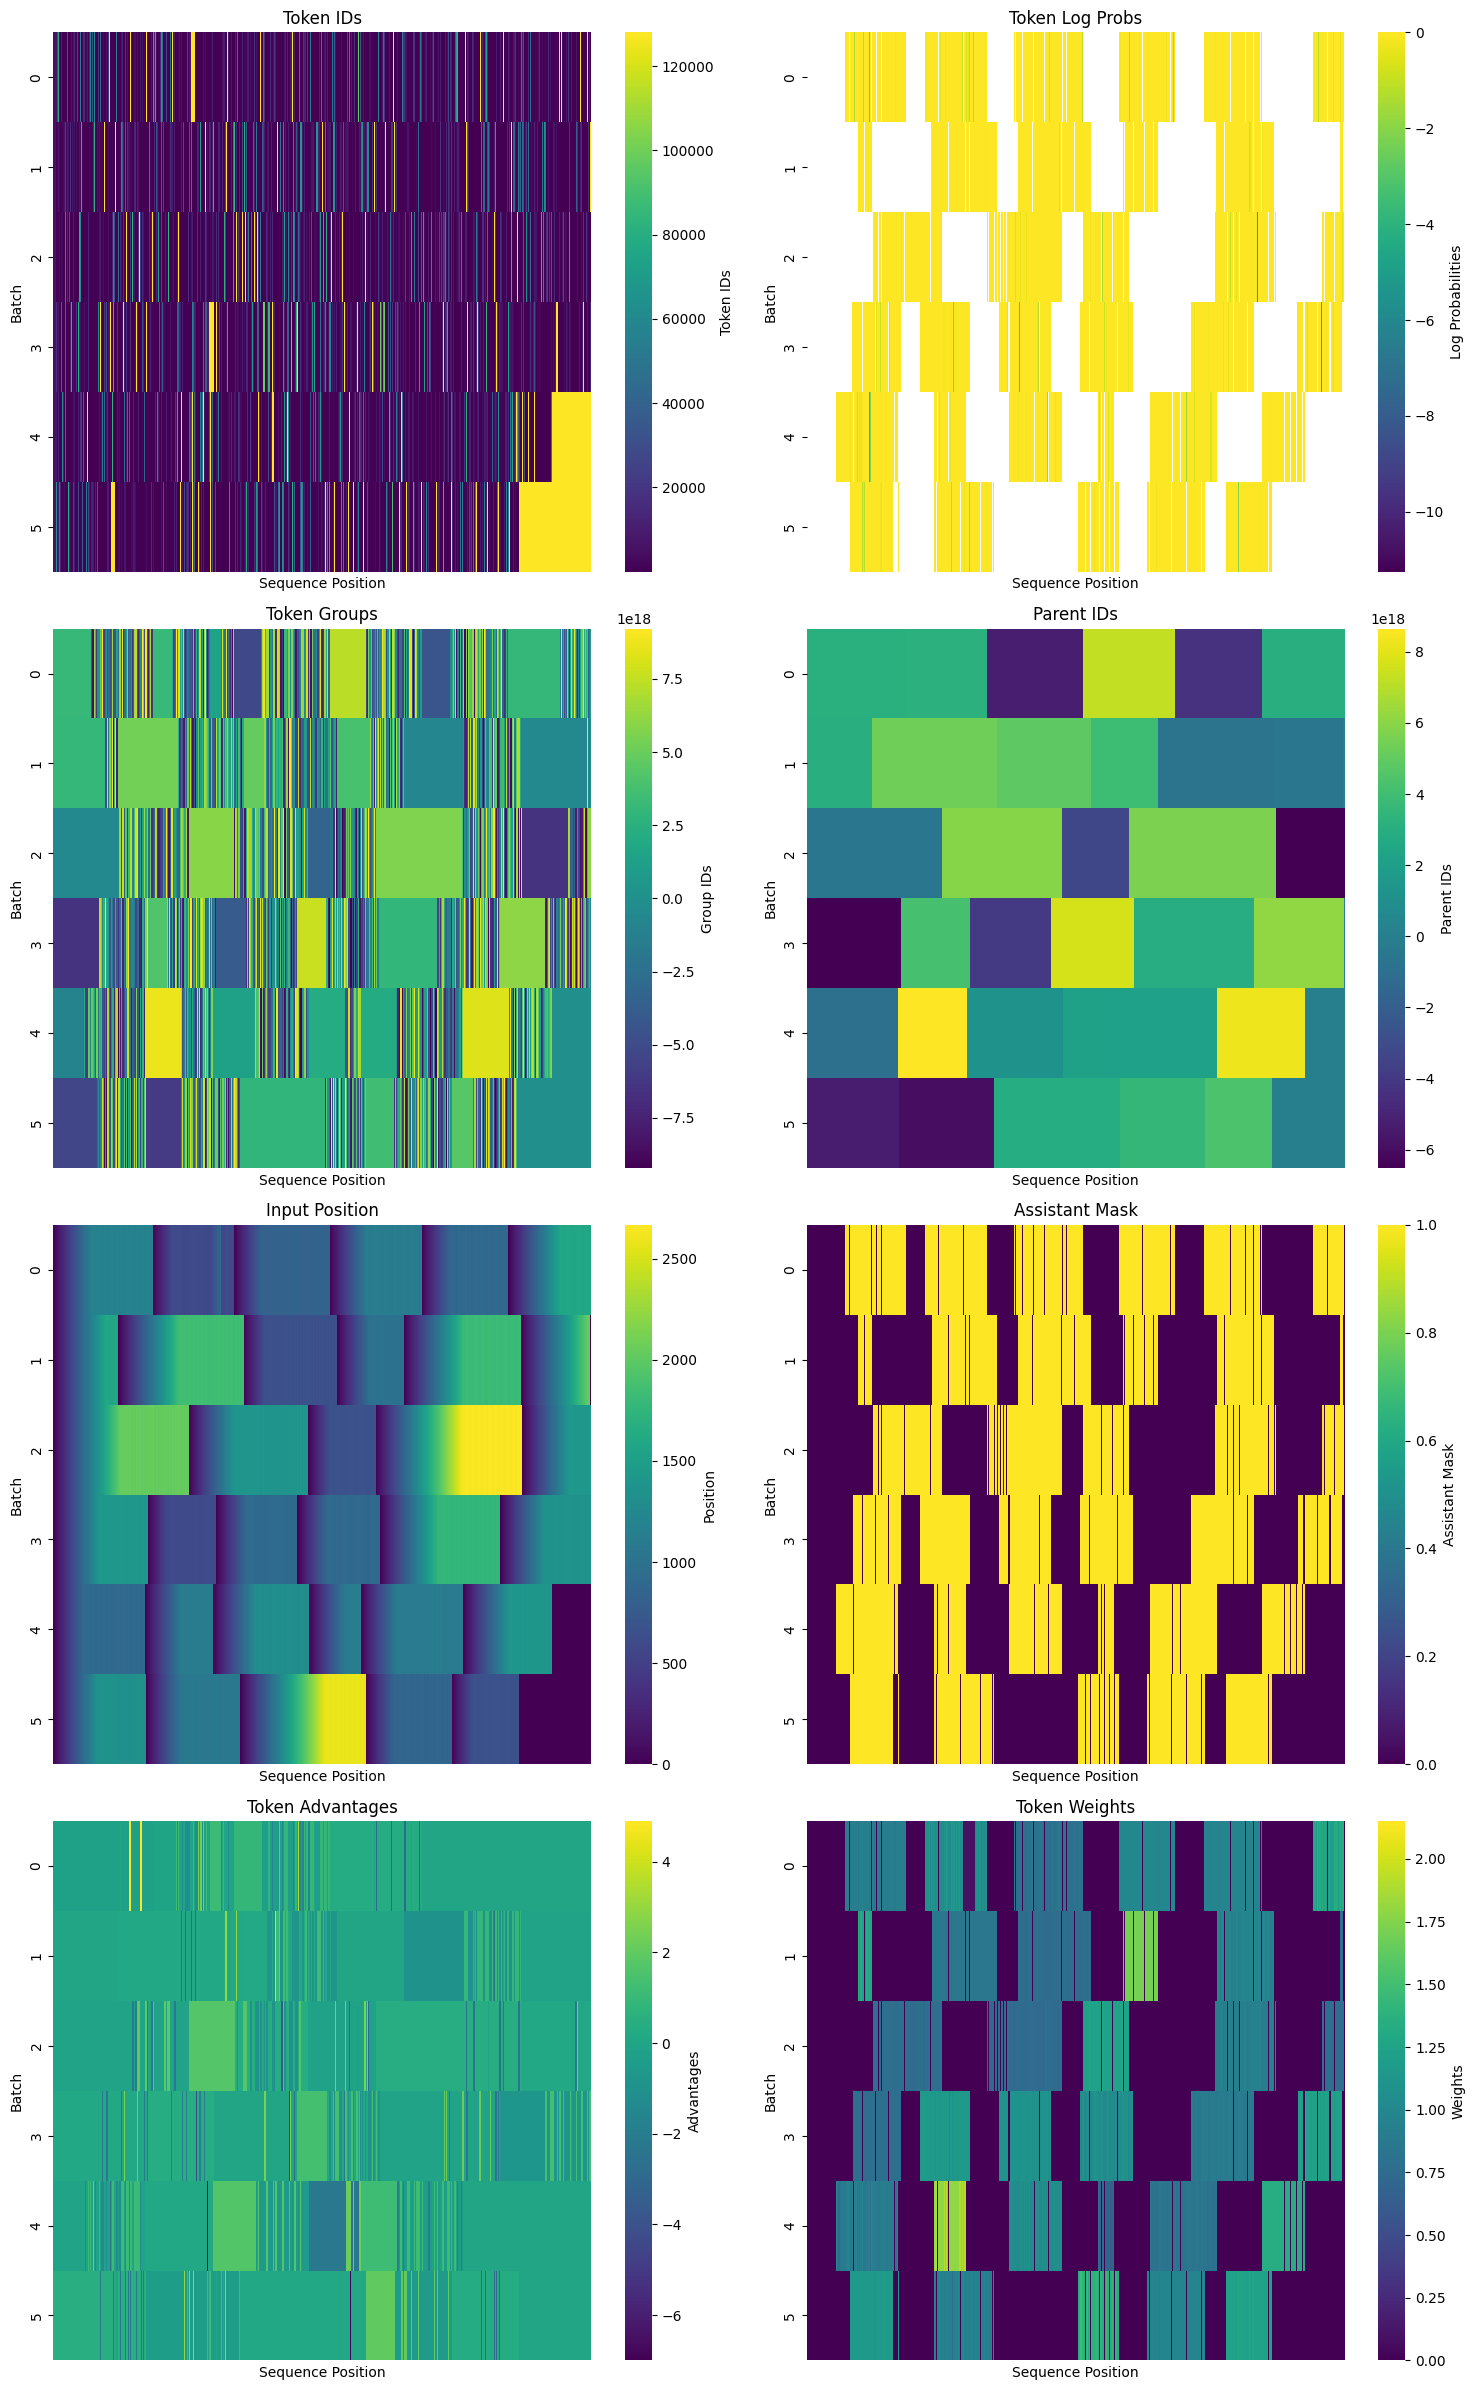

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-004/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-004/0007
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-004
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-004/logs/log_1741965898.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.31 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|3|Loss: 0.0319: 100%|██████████| 3/3 [01:06<00:00, 21.21s/it, loss=0.0319, policy=0.0319, entropy=0.0374, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0008 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-004 --port=8000 --api-key=default
INFO 03-14 15:26:41 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 15:26:41 api_server.py:912] vLLM API server version 0.7.3
INFO 03-14 15:26:41 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0008', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_tem

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.73it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.60it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.26it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.12it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.26it/s]



INFO 03-14 15:26:56 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-14 15:26:58 worker.py:267] Memory profiling takes 1.25 seconds
INFO 03-14 15:26:58 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-14 15:26:58 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-14 15:26:58 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-14 15:26:58 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-14 15:27:48 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 51.83 seconds
INFO 03-14 15:27:49 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-14 15:27:49 launcher.py:23] Available routes are:
INFO 03-14 15:27:49 launcher.py:31] Route: /openapi.json, Methods: GET,

INFO:     Started server process [13719]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-14 15:27:53 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:55356 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/temporal-clue-004/0006
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Resu

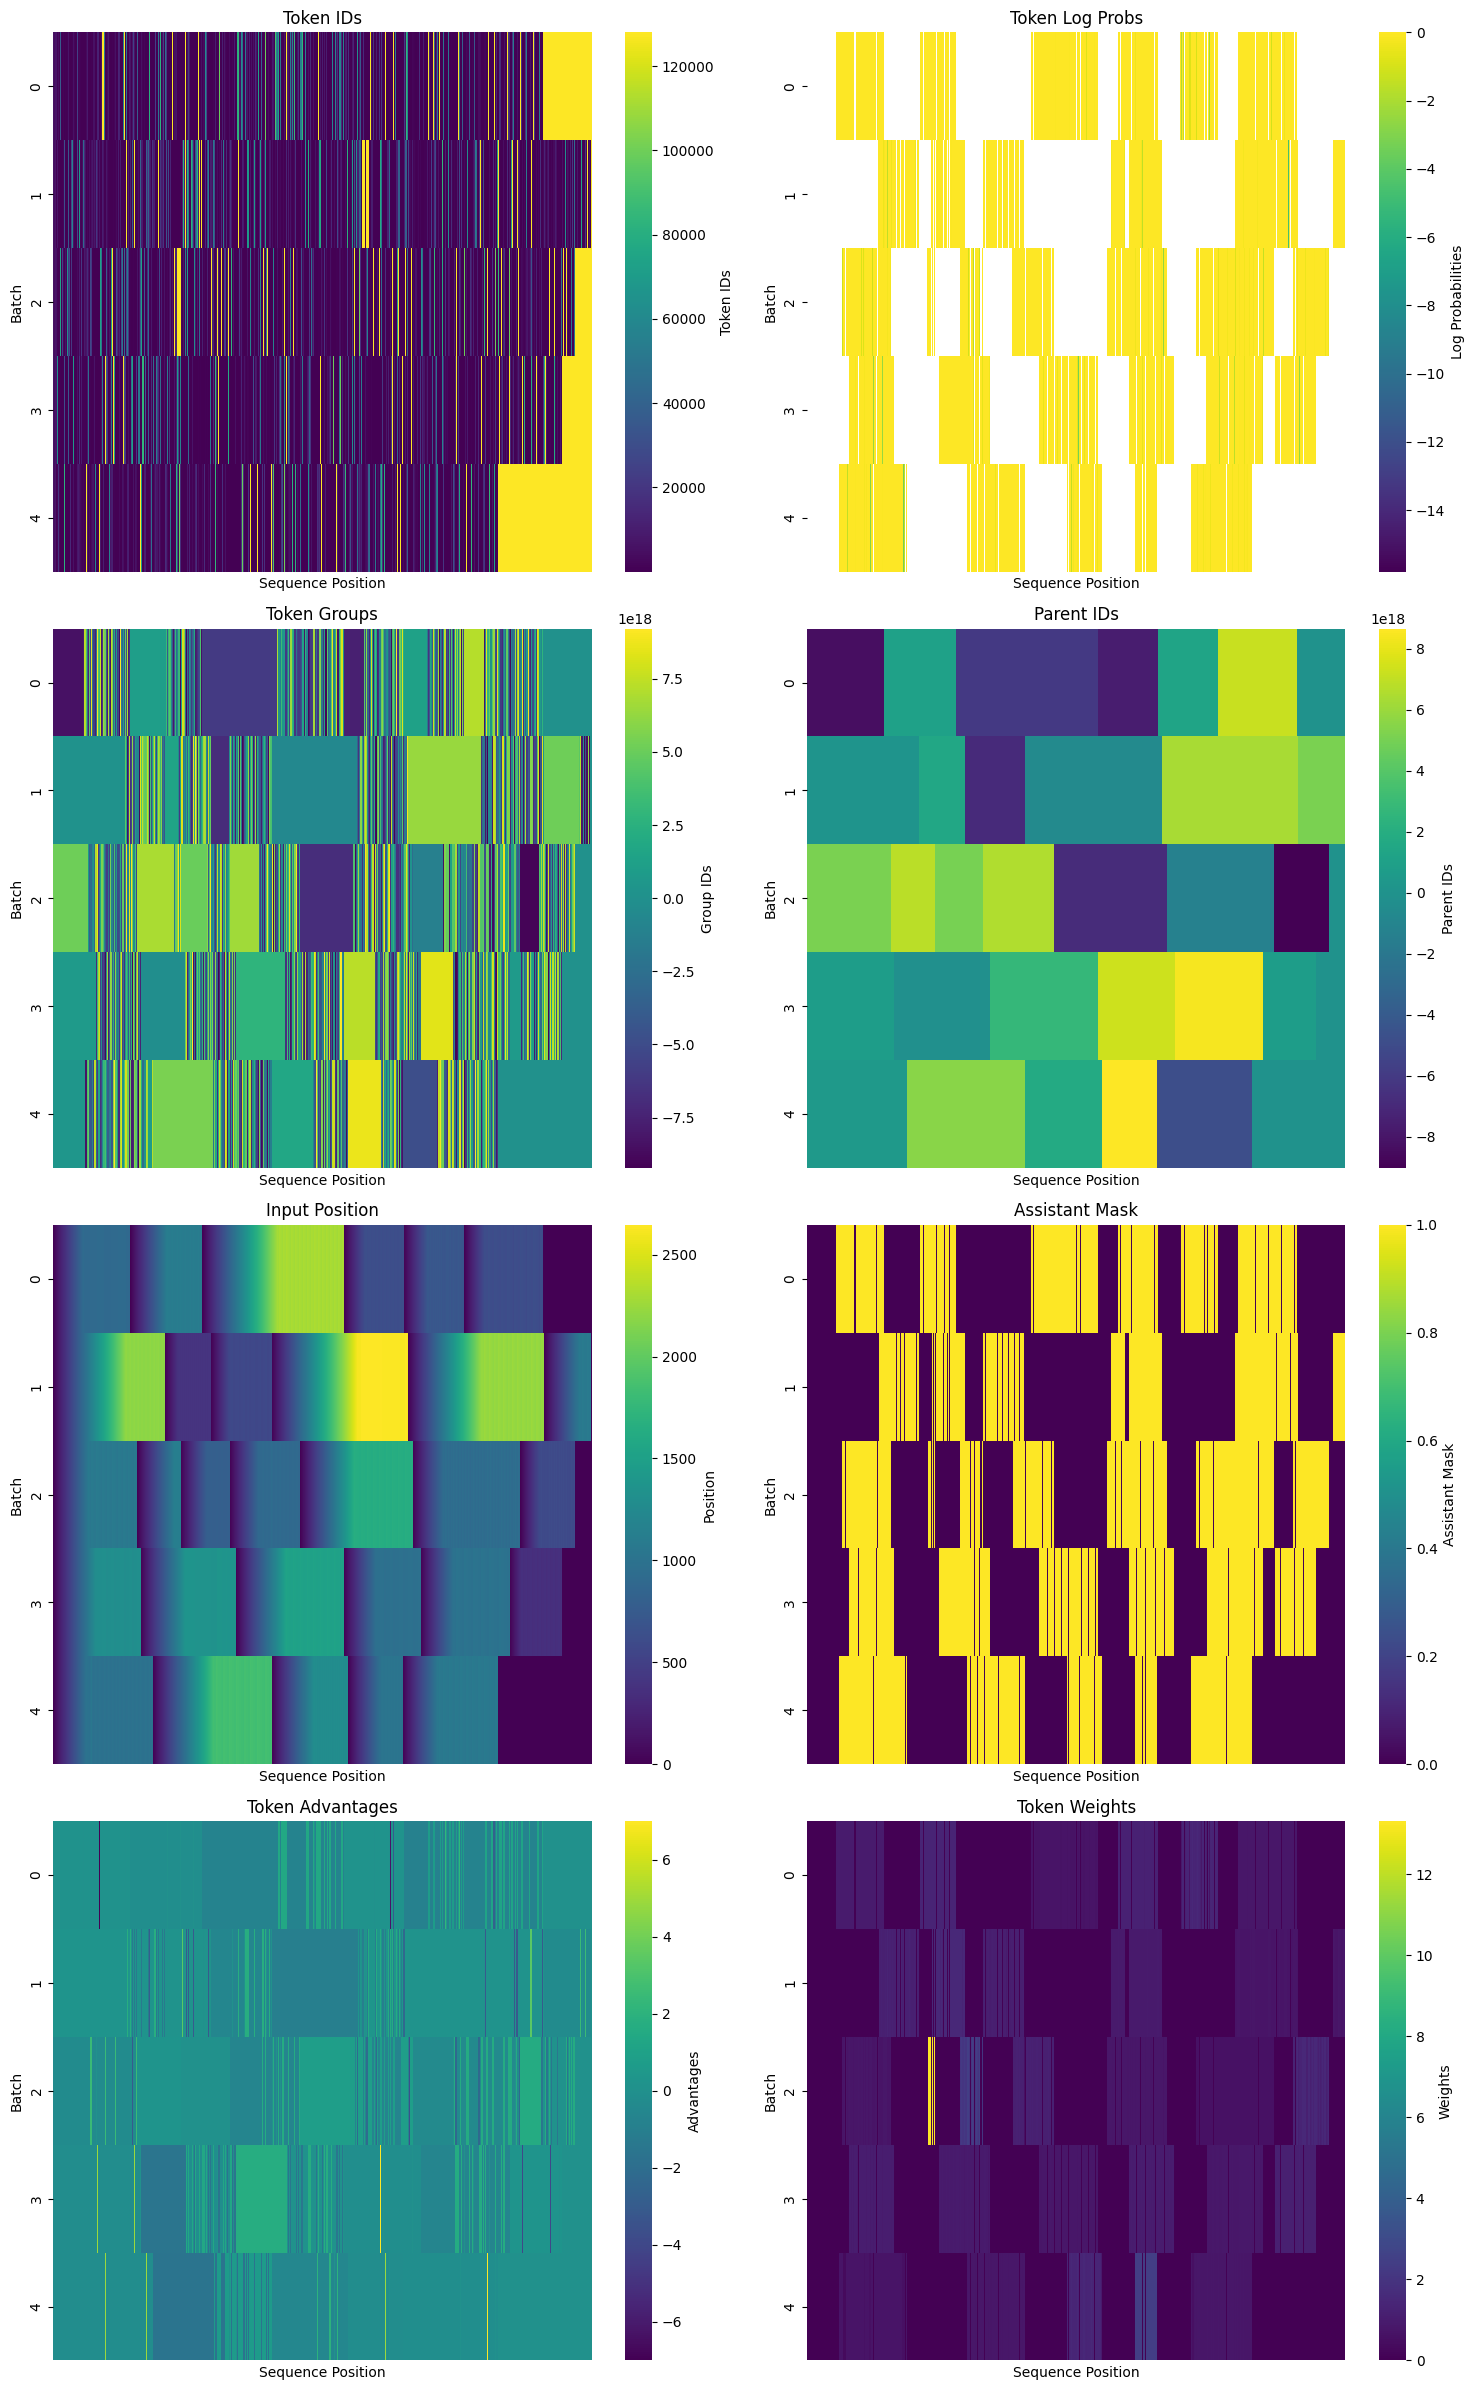

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-004/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-004/0008
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-004
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-004/logs/log_1741966150.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.30 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|2|Loss: 0.0217: 100%|██████████| 2/2 [00:45<00:00, 22.23s/it, loss=0.0217, policy=0.0217, entropy=0.0417, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0009 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-004 --port=8000 --api-key=default
INFO 03-14 15:30:31 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 15:30:31 api_server.py:912] vLLM API server version 0.7.3
INFO 03-14 15:30:31 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0009', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_tem

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.77it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.60it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.26it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.14it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.28it/s]



INFO 03-14 15:30:47 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 03-14 15:30:49 worker.py:267] Memory profiling takes 1.31 seconds
INFO 03-14 15:30:49 worker.py:267] the current vLLM instance can use total_gpu_memory (79.19GiB) x gpu_memory_utilization (0.95) = 75.23GiB
INFO 03-14 15:30:49 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 9.45GiB; the rest of the memory reserved for KV Cache is 50.67GiB.
INFO 03-14 15:30:49 executor_base.py:111] # cuda blocks: 12972, # CPU blocks: 20480
INFO 03-14 15:30:49 executor_base.py:116] Maximum concurrency for 8192 tokens per request: 50.67x
INFO 03-14 15:31:38 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 50.70 seconds
INFO 03-14 15:31:39 api_server.py:958] Starting vLLM API server on http://0.0.0.0:8000
INFO 03-14 15:31:39 launcher.py:23] Available routes are:
INFO 03-14 15:31:39 launcher.py:31] Route: /openapi.json, Methods: GET,

INFO:     Started server process [14180]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO 03-14 15:31:41 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:47722 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/1600 [00:00<?, ?it/s]

Deleted iteration directory ./.art/models/temporal-clue-004/0007


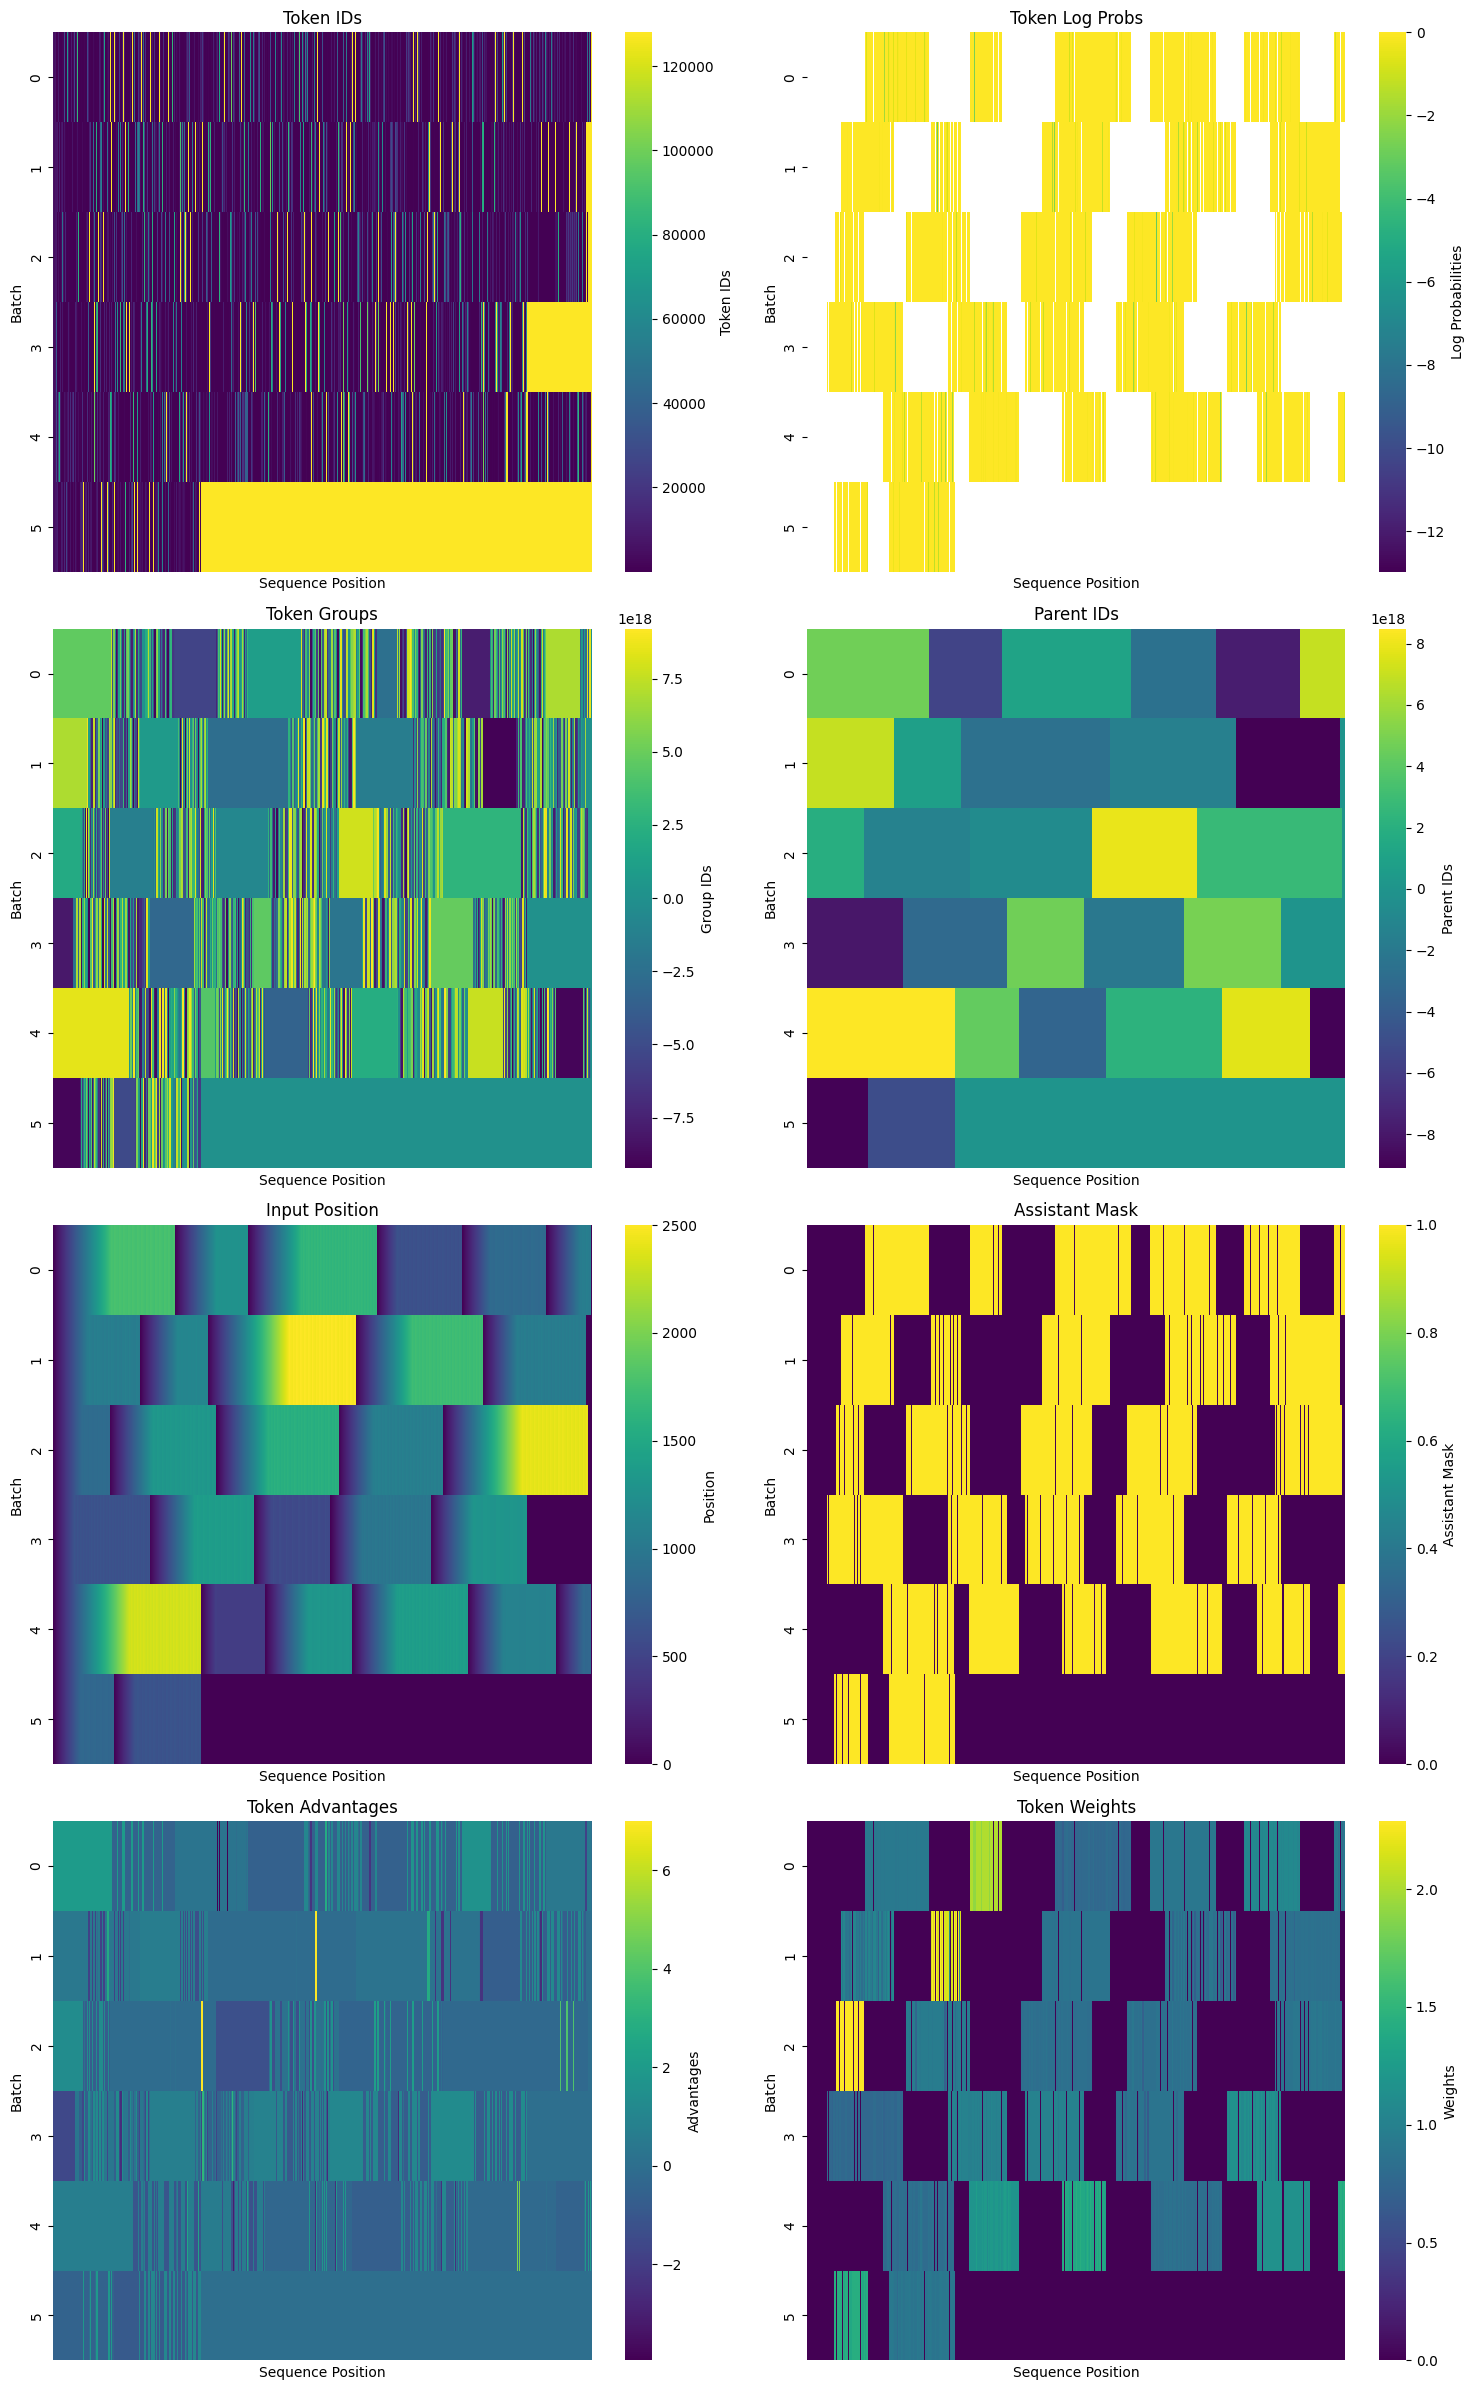

$ tune run art.local.recipe.TuneRecipe --config ./.art/models/temporal-clue-004/config.yaml


<frozen runpy>:128: RuntimeWarning: 'art.local.recipe' found in sys.modules after import of package 'art.local', but prior to execution of 'art.local.recipe'; this may result in unpredictable behaviour
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./.art/models/temporal-clue-004/0009
  checkpoint_files:
  - ft-model-00004-of-00004.safetensors
  - ft-model-00001-of-00004.safetensors
  - ft-model-00003-of-00004.safetensors
  - ft-model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./.art/models/temporal-clue-004
  recipe_checkpoint: null
compile: true
custom_sh

Writing logs to .art/models/temporal-clue-004/logs/log_1741966386.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.62 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.02 GiB
	GPU peak memory reserved: 15.14 GiB
	GPU peak memory active: 15.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|3|Loss: 0.0417: 100%|██████████| 3/3 [01:03<00:00, 20.41s/it, loss=0.0417, policy=0.0417, entropy=0.0555, kl_div=nan]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO

$ vllm serve /home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0010 --block-size=32 --disable-log-requests --enable-chunked-prefill --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=2048 --max-num-batched-tokens=16384 --num-scheduler-steps=16 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --tool-call-parser=hermes --served-model-name=temporal-clue-004 --port=8000 --api-key=default
INFO 03-14 15:34:45 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 15:34:45 api_server.py:912] vLLM API server version 0.7.3
INFO 03-14 15:34:45 api_server.py:913] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/examples/.art/models/temporal-clue-004/0010', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_tem

In [ ]:
import art
import asyncio
from dotenv import load_dotenv
import json
import openai
import random
import re
from typing import TypedDict

load_dotenv()


class TemporalCluePuzzle(TypedDict):
    num_clues: int
    prompt: str
    solution: dict[str, str]


puzzles: list[TemporalCluePuzzle] = json.load(open("./data/temporal-clue/puzzles.json"))
val_puzzles = puzzles[:64]
test_puzzles = puzzles[64:128]
train_puzzles = puzzles[128:]
random.seed(42)
random.shuffle(train_puzzles)


api = art.LocalAPI(wandb_project="agent-reinforcement-training")
model = await api.get_or_create_model(
    name="temporal-clue-004", base_model="NousResearch/Hermes-2-Theta-Llama-3-8B"
)


async def rollout(
    client: openai.AsyncOpenAI, puzzle: TemporalCluePuzzle
) -> art.Trajectory:
    messages: art.Messages = [{"role": "user", "content": puzzle["prompt"]}]
    chat_completion = await client.chat.completions.create(
        messages=messages, model=model.name
    )
    choice = chat_completion.choices[0]
    content = choice.message.content
    assert isinstance(content, str)
    num_correct = 0
    for key, value in puzzle["solution"].items():
        if matches := re.findall(rf"{key}\. ([A-Za-z \.:-]+)", content):
            match = matches[-1]
            if match.strip().lower() == value.lower():
                num_correct += 1
    reward = acc = num_correct / len(puzzle["solution"])
    return art.Trajectory(
        messages_and_choices=[*messages, choice], reward=reward, metrics={"acc": acc}
    )


stride = 32
for i in range(await model.get_iteration(), 1_000):
    async with model.openai_client(verbosity=2) as openai_client:
        val_groups, train_groups = await asyncio.gather(
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(2))
                    for puzzle in val_puzzles
                ),
                pbar_desc="val",
            ),
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(50))
                    for puzzle in train_puzzles[i * stride : (i + 1) * stride]
                ),
                pbar_desc="train",
            ),
        )
    await model.save(val_groups)
    await model.clear_iterations()
    await model.tune(
        train_groups, config=art.TuneConfig(plot_tensors=True, verbosity=2)
    )